# Analysis of Cohort Data

## Contents:

#### Time (Seasonal) analysis on patient entry times. Is there a pattern for which months frequent flyers enter compared to regular patients? 

#### Time (Hourly) analysis on patient entry times. Is there a pattern for which hours frequent flyers enter compared to regular patients? 

#### A look at how many prescriptions are given out to both frequent flyers and regular patients


## Setup & Reading from files

In [33]:
%matplotlib inline
# notebook
import matplotlib.pylab as pylab
import sklearn
import matplotlib.pyplot as plt


#make the graphs bigger
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

In [34]:
cohort = []
ETOH = []
hw = []
labOrders = []
medOrders = []
prescriptions = []
radiology = []
tobacco = []
vitals = []

In [35]:
#get list representation of a file
def fileToList(fname):
    dataArray = []
    with open(fname) as f:
        for line in f:
            new = line.strip()
            new = new[1:len(new) - 1]
            new = new.split('","')
            if (len(new) > 1):
                dataArray.append(new)
    return dataArray

In [36]:
#represent a file by indexing on a patient's id in a dictonary
def fileToDict(fname):
    dataDict = dict()
    with open(fname) as f:
        for line in f:
            new = line.strip()
            new = new[1:len(new) - 1]
            new = new.split('","')
            if (len(new) > 1):
                if not(new[0] in dataDict):
                    dataDict[new[0]] = [new]
                else:
                    dataDict[new[0]].append(new)
    return dataDict

In [37]:
fname = "2018-4169_Cohort.txt"
cohort = fileToList(fname)

fname = "2018-4169_ETOH_Use.txt"
ETOH = fileToDict(fname)

fname = "2018-4169_Height_Weight.txt"
hw = fileToDict(fname)

fname = "2018-4169_Lab_Orders_Performed.txt"
labOrders = fileToDict(fname)


In [38]:
fname = "2018-4169_Med_Orders.txt"
medOrders = fileToDict(fname)

fname = "2018-4169_Prescriptions.txt"
prescriptions = fileToList(fname)

In [39]:
fname = "2018-4169_Radiology_Orders.txt"
radiology = fileToDict(fname)

fname = "2018-4169_Tobacco_Use.txt"
radiology = fileToDict(fname)

In [40]:
fname = "2018-4169_Vital_Signs.txt"
#radiology = fileToList(fname)

In [41]:
import collections

#returns a dict of dicts of lists
#dict of years
 #dict of visit ids
  #list of prescription entries per patient
def organisePrescriptions(myPrescriptions):
    organised = dict()
    for admission in myPrescriptions:
        year = admission[-1][0:4]
        if year in organised:
            entry = organised[year]
            if admission[1] in entry:
                organised[year][admission[1]].append([admission[0]]+admission[1:])
            else:
                organised[year][admission[1]] = [[admission[0]]+admission[1:]]
        else:
            patientData = dict()
            patientData[admission[1]] = [[admission[0]]+admission[1:]]
            organised[year] = patientData
    return organised
    

In [42]:
import collections

#returns a dict of dicts of lists
#dict of years
 #dict of patients
  #list of admissions
def organiseCohortData(myCohort):
    organised = dict()
    for admission in myCohort:
        year = admission[8][0:4]
        if year in organised:
            entry = organised[year]
            if admission[0] in entry:
                organised[year][admission[0]].append(admission[1:])
            else:
                organised[year][admission[0]] = [admission[1:]]
        else:
            patientData = dict()
            patientData[admission[0]] = [admission[1:]]
            organised[year] = patientData
    return organised
    

In [43]:
#given an organised cohort dictionary
def getFrequentFlyers(dataDict, year=None):
    if (year == None):
        freqDict = dict()
        for key in dataDict:
            freqDict[key] = []
            patientDict = dataDict[key]
            for pKey in patientDict:
                if len(patientDict[pKey]) > 5:
                    freqDict[key].append(pKey)
        return freqDict
    else:
        freqDict= dict()
        if (year in dataDict):
            patientDict = dataDict[year]
            for pKey in patientDict:
                if len(patientDict[pKey]) > 5:
                    freqDict[key].append(pKey)
            return freqDict
        else:
            return dict()

In [44]:
#get chronic frequent flyers from frequent flyers
def getChronicFrequentFlyers(frequentFlyers):
    exists = True
    shortest = 300000
    lowestYear = None
    for key in frequentFlyers:
        if len(frequentFlyers[key]) < shortest:
            lowestYear = key
    
    patientDict = frequentFlyers[lowestYear]
    chronic = []
    for pKey in patientDict:
        inAll = True
        for year in frequentFlyers.keys():
            inAll = inAll and (pKey in frequentFlyers[year])
        if (inAll):
            chronic.append(pKey)
                
    return chronic
    

In [45]:
from copy import copy,deepcopy

#gets an organsed list of non frequent flyers
def getNonFrequentFlyers(cohortDict, frequentFlyerDict):
    regular = dict()
    for year in cohortDict:
        regular[year] = dict()
        patList = cohortDict[year]
        for pKey in patList:
            if not(pKey in frequentFlyerDict[year]):
                regular[year][pKey] = cohortDict[year][pKey]
    return regular

In [46]:
organised = organiseCohortData(cohort[1:])
frequents = getFrequentFlyers(organised)
chronic = getChronicFrequentFlyers(frequents)
regulars = getNonFrequentFlyers(organised, frequents)

In [47]:
#returns the list of entries for a particular patient
def instances(patientId, year):
    return organised[year][patientId]

In [48]:
#average time between visits
from datetime import datetime

#gets a date from a string
def toDate(k):
    return datetime.strptime(k[7][0:10], '%Y-%m-%d')

#gets number of days between 2 days
def distance(date1, date2):
    return (date1-date2).days

#gets the number of days between successive visits for a patients list of entries
def computeJumps(deId, year):
    admissions = instances(deId, year)
    dates = list(map(toDate, admissions))
    dates = sorted(dates)
    jumps = [distance(j,i) for i, j in zip(dates[:-1], dates[1:])]
    return sum(jumps)/len(jumps)


## Charts how many months pass on average between visits for a frequent flyer

Want to understand a bit more about what an average frequent flyer looks like. Do all 5 visits happen in a month or is it more drawn out?

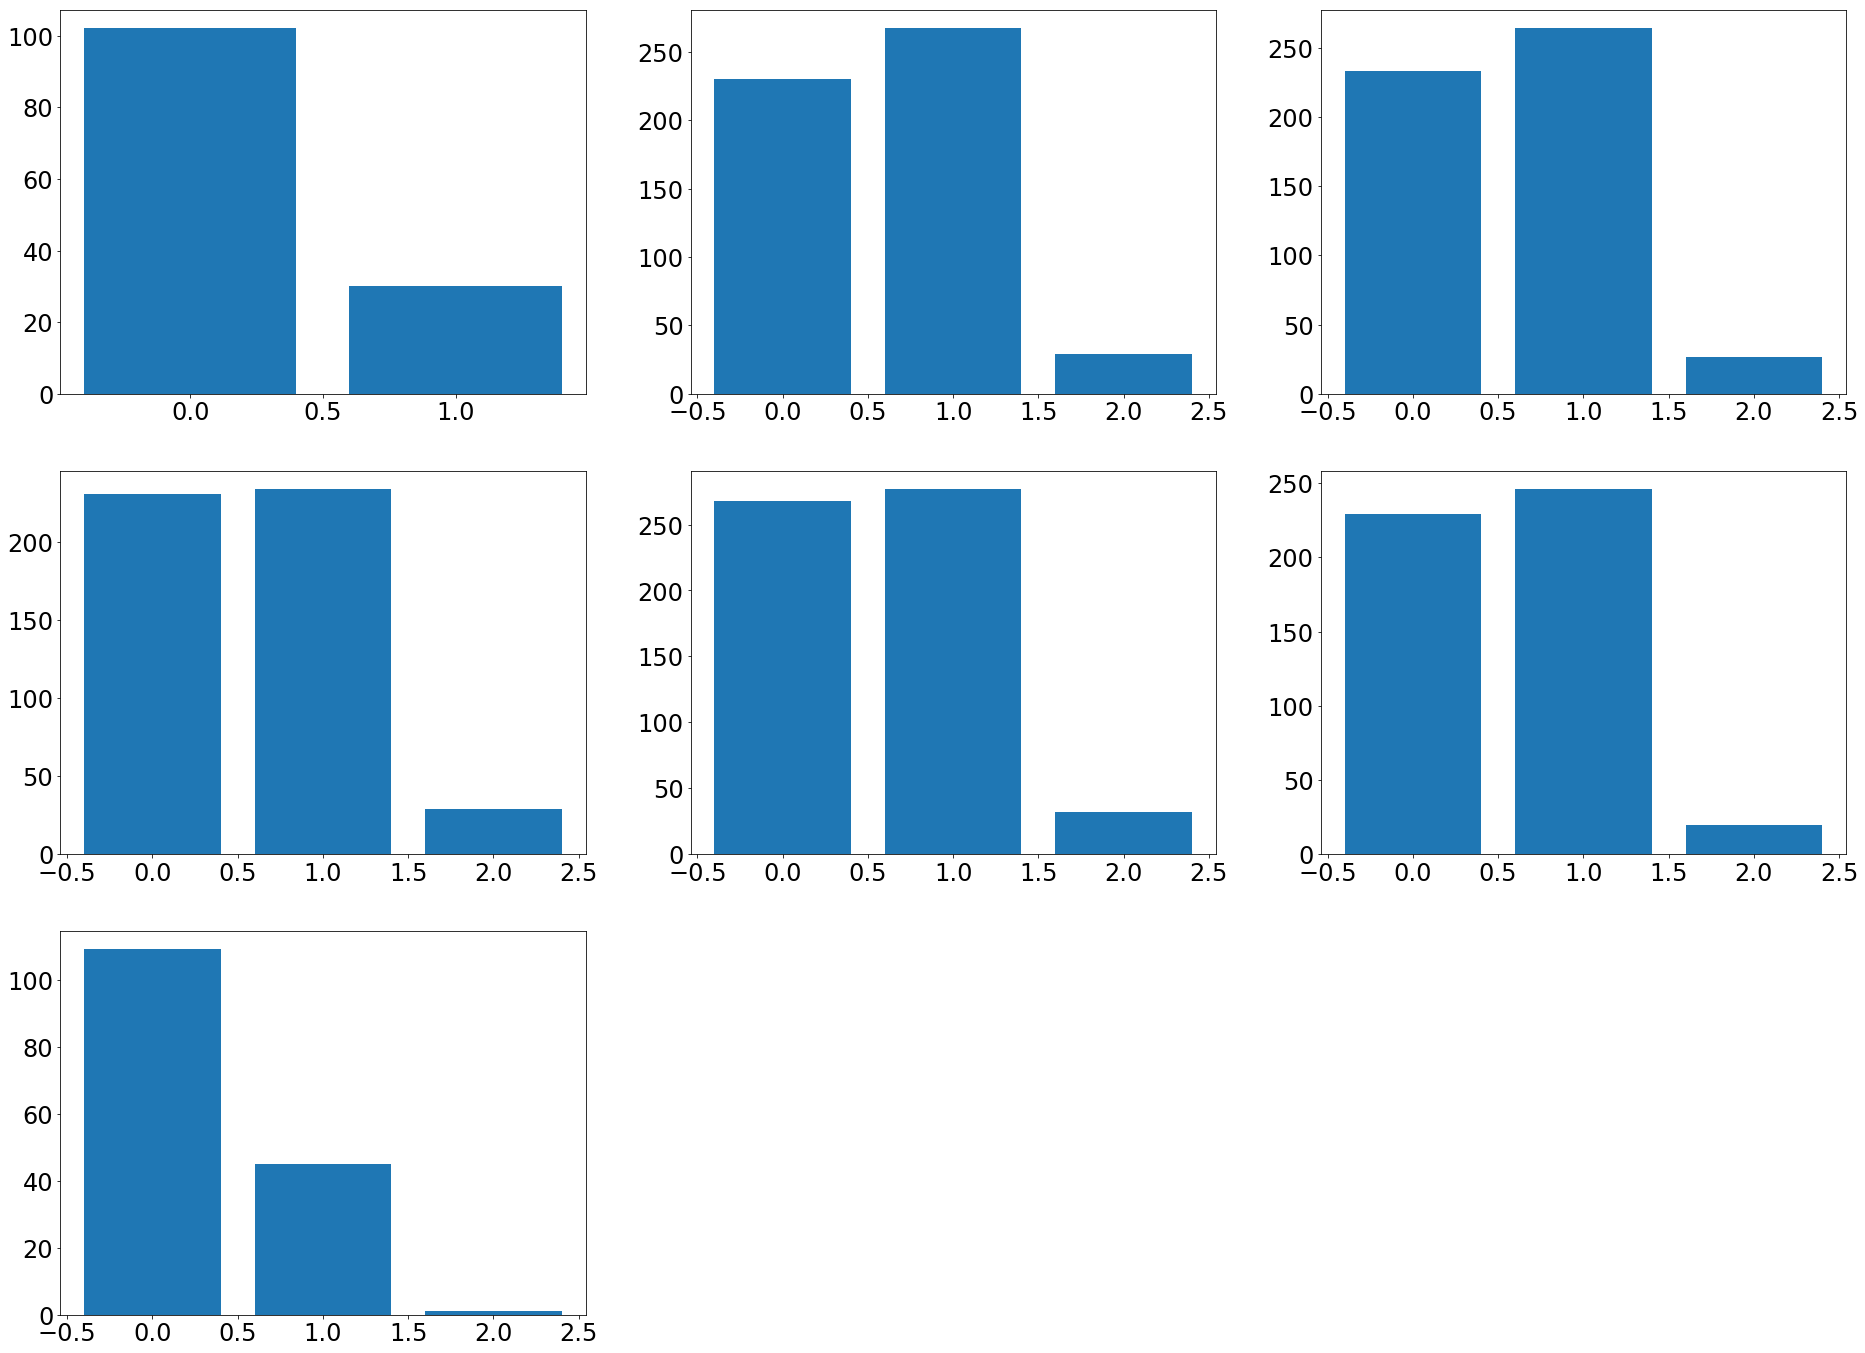

In [102]:
fig = plt.figure()
plotId = 0
keys = list(frequents.keys())
for key in keys:
    charting = []
    plotId = plotId + 1
    for k in frequents[key]:
        j = computeJumps(k, key)
        j = math.floor(j/30)
        charting.append(j)
    ax = fig.add_subplot( 3, 3, plotId )
    bins=collections.Counter(charting)
    ax.bar(list(bins.keys()), list(bins.values()))
        
plt.show()

# Month Based Time Analysis

## Aggregated Entry Times

Gets the entry month of each of the frequent flyers per year, then plots every one on the chart. Idea is to find any trends in the months that frequent flyers enter.

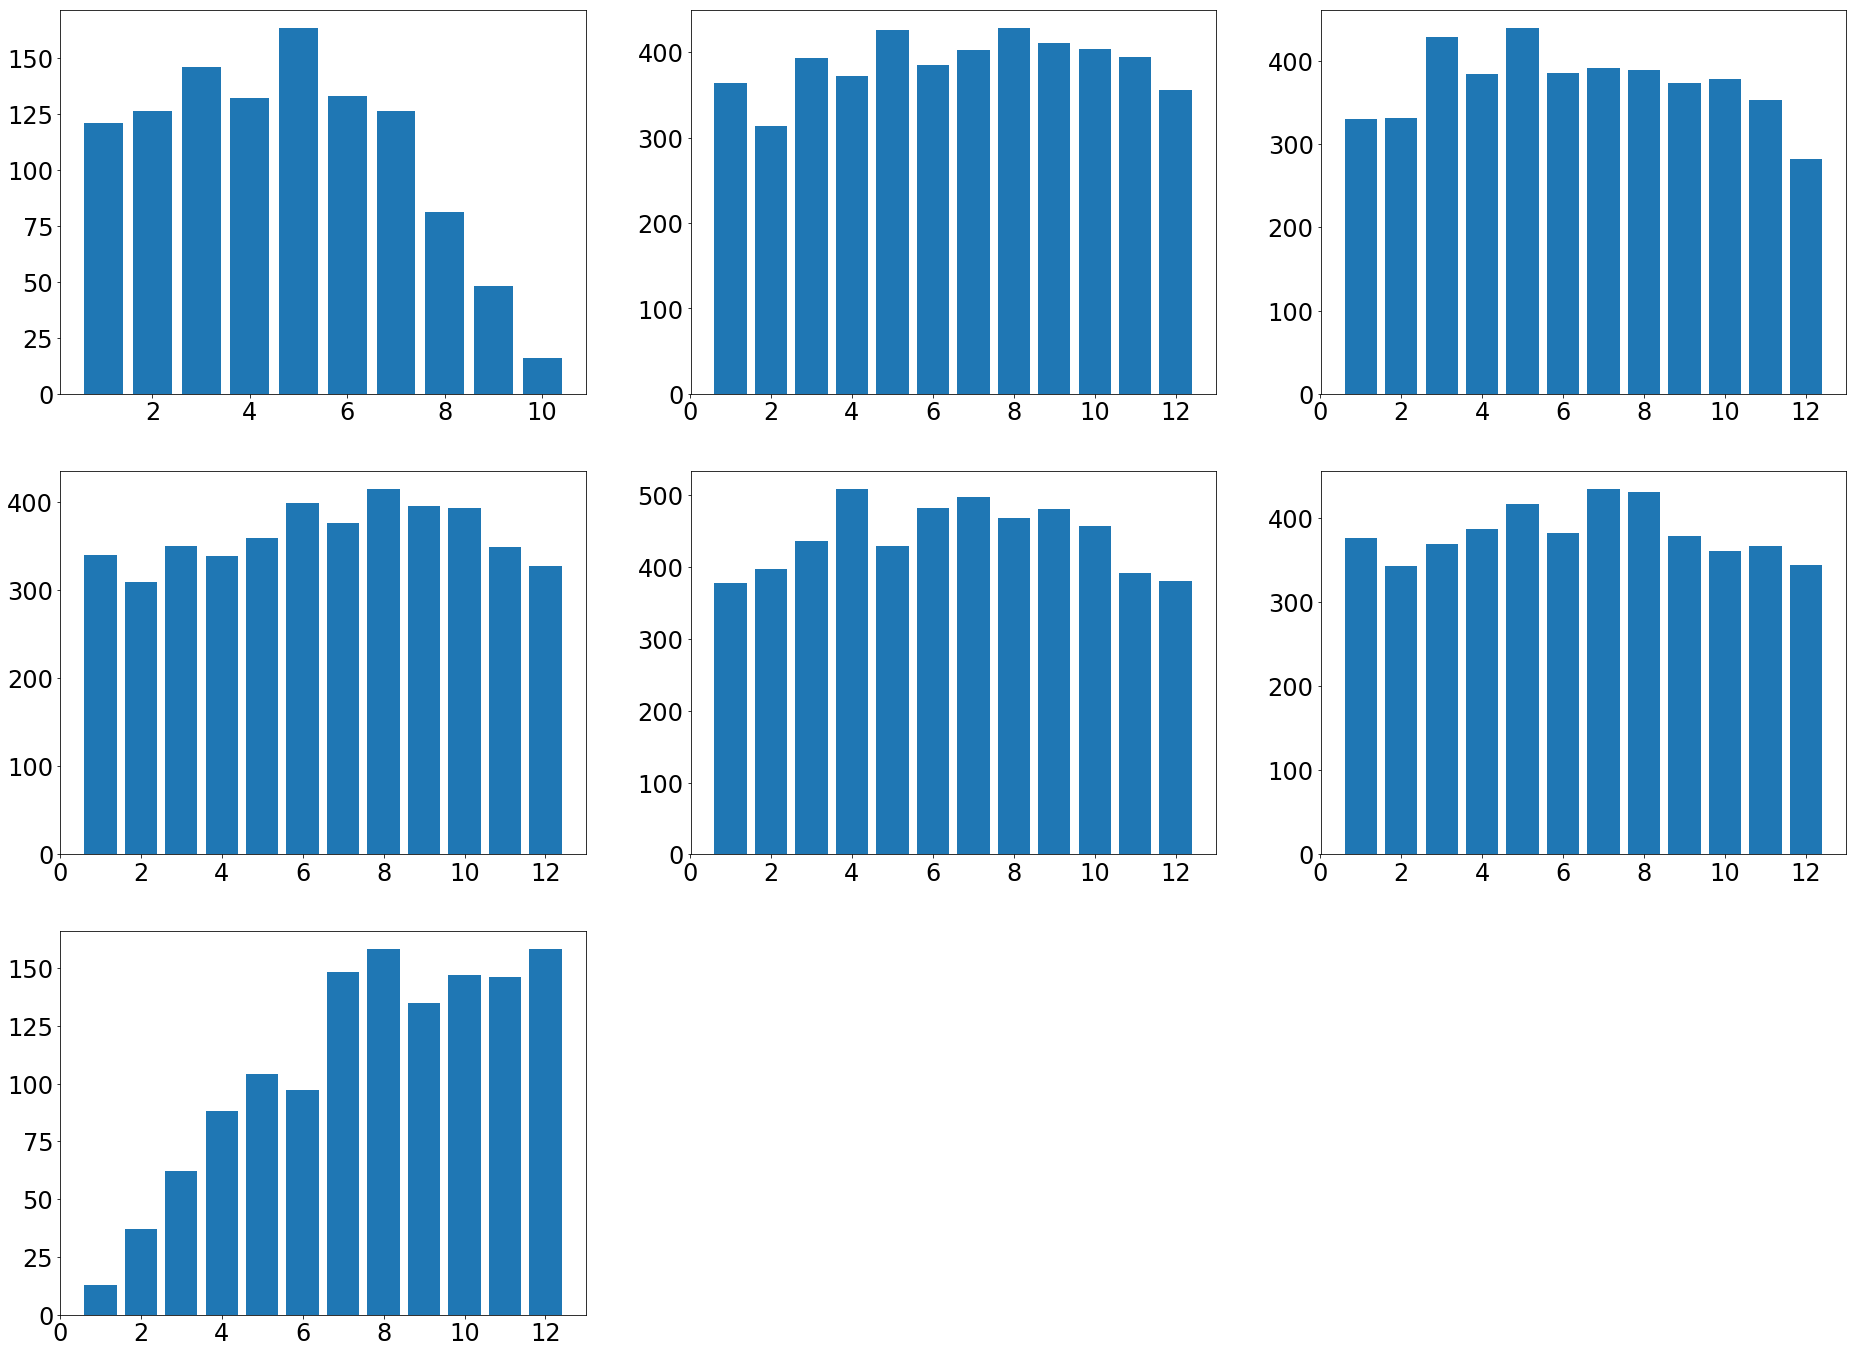

In [106]:
fig = plt.figure()
plotId = 0
keys = list(frequents.keys())
for key in keys:
    charting = []
    plotId = plotId + 1
    for k in frequents[key]:
        admissions = instances(k, key)
        for a in admissions:
            charting.append(toDate(a).month)
    ax = fig.add_subplot( 3, 3, plotId )
    bins=collections.Counter(charting)
    ax.bar(list(bins.keys()), list(bins.values()))
        
plt.show()

Repeated algorithm from above, but for the regular cohort

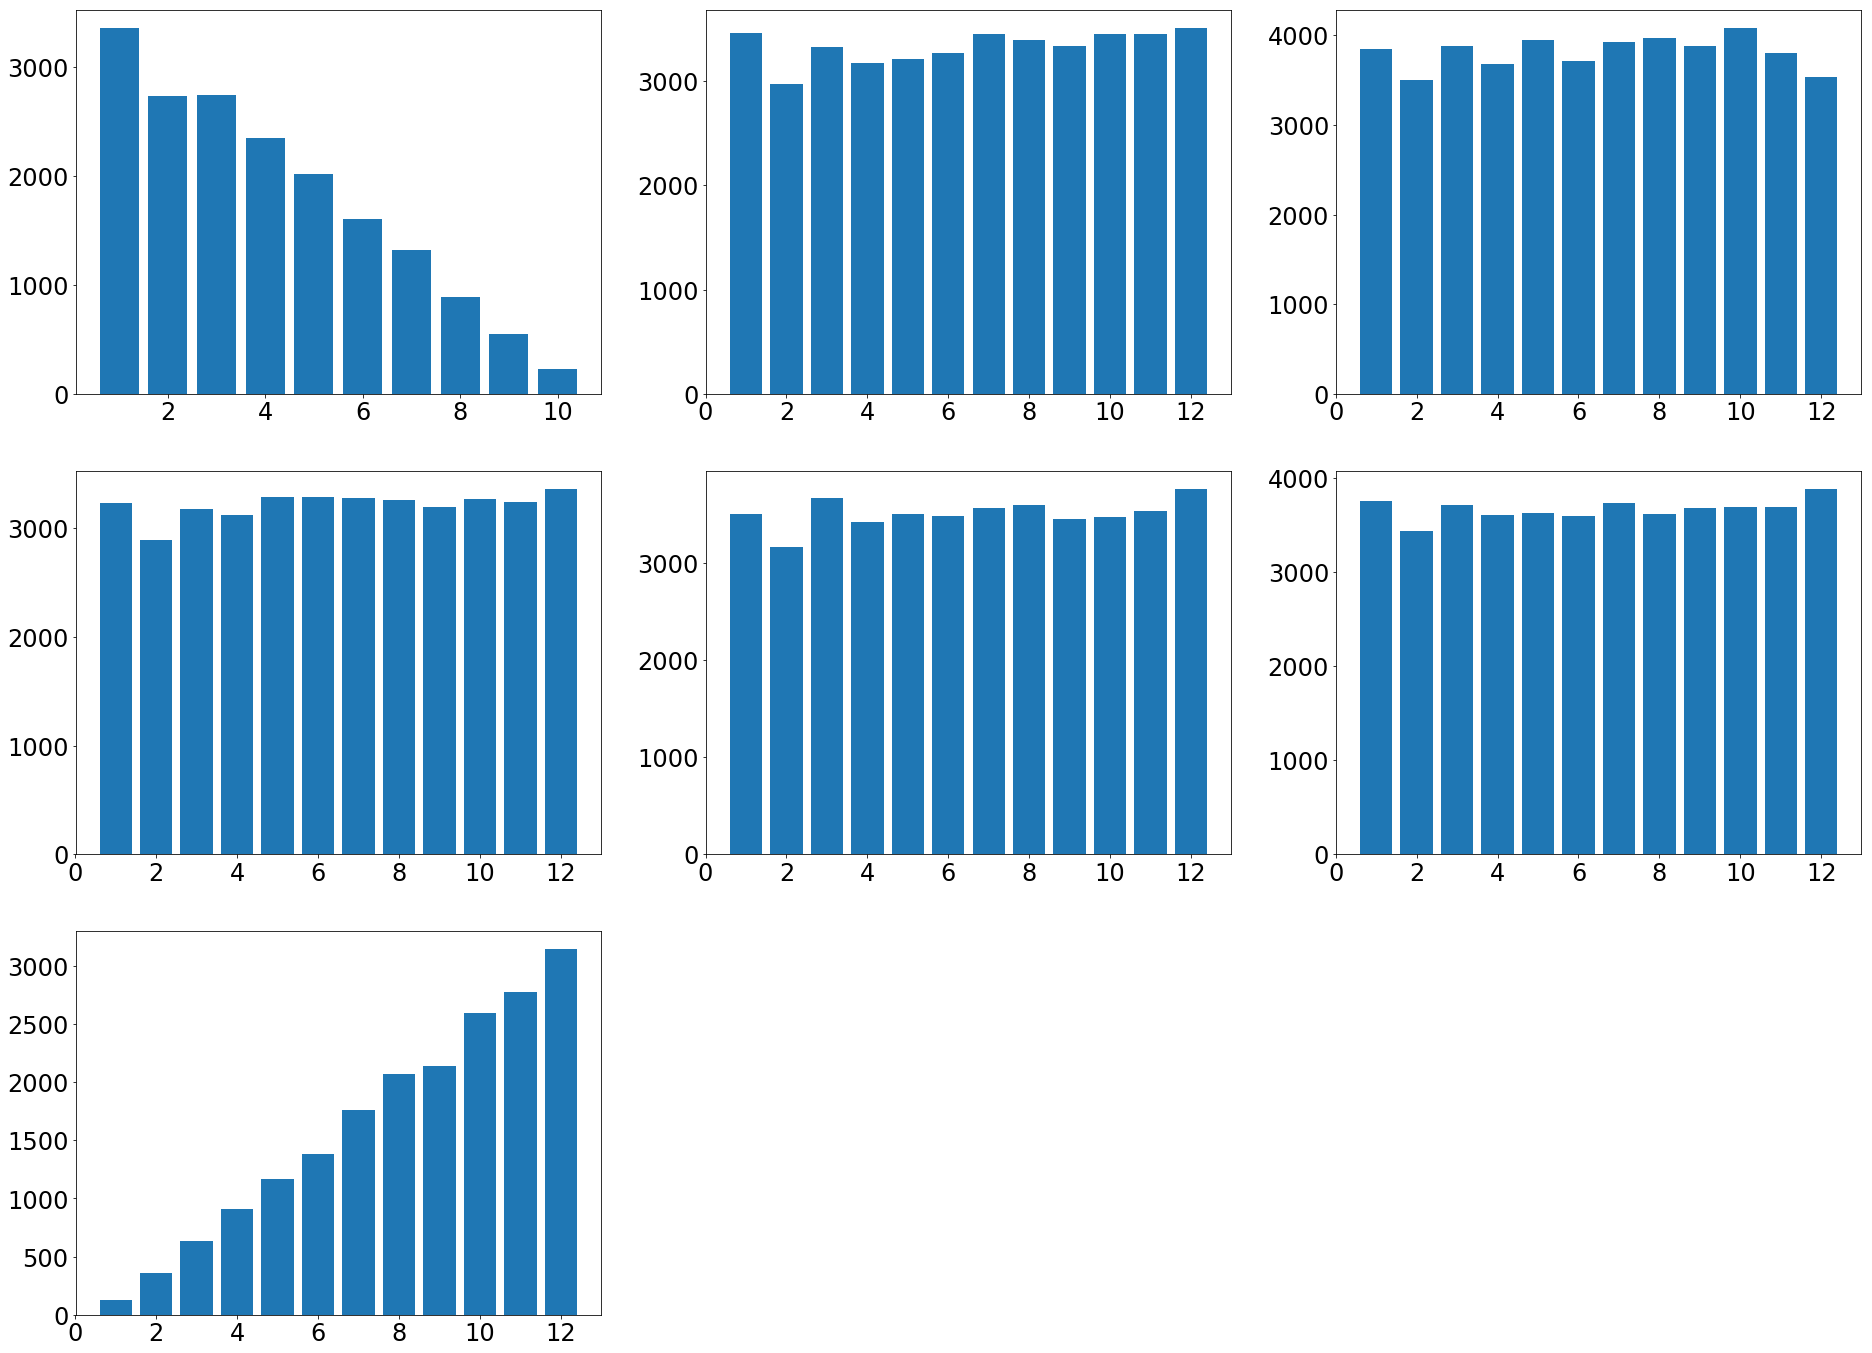

In [112]:
fig = plt.figure()
plotId = 0
keys = list(regulars.keys())
for key in keys:
    charting = []
    plotId = plotId + 1
    for k in regulars[key]:
        admissions = instances(k, key)
        for a in admissions:
            charting.append(toDate(a).month)
    ax = fig.add_subplot( 3, 3, plotId )
    bins=collections.Counter(charting)
    ax.bar(list(bins.keys()), list(bins.values()))
        
plt.show()

## Max Months 

This function will analyse the entry times of frequent flyers, get their most common month across the few years, and plot the max month of the frequent flyers

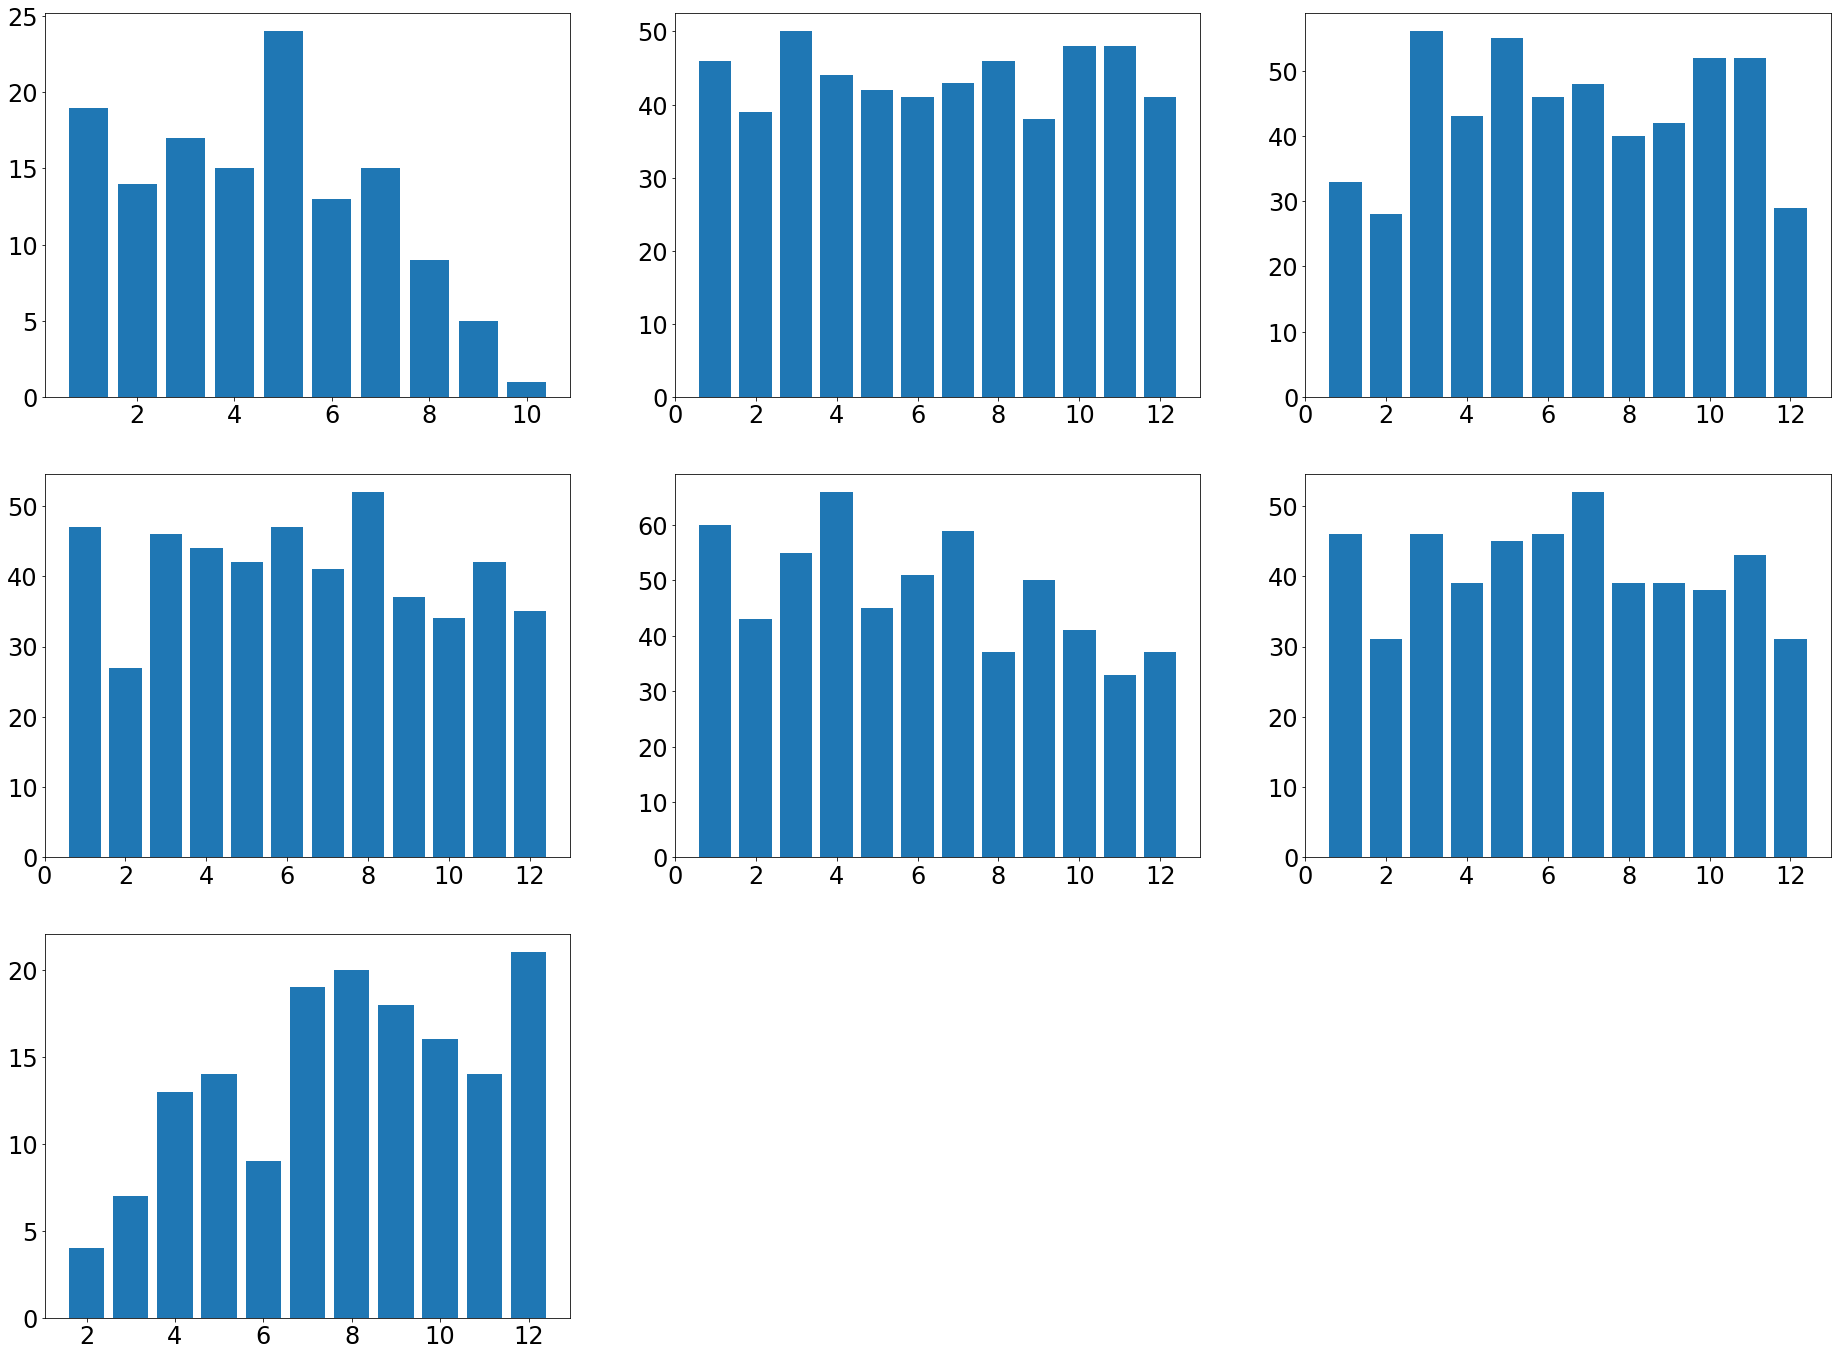

In [114]:
fig = plt.figure()
plotId = 0
keys = list(frequents.keys())
for key in keys:
    charting = []
    plotId = plotId + 1
    for k in frequents[key]:
        admissions = instances(k, key)
        maxes = []
        for a in admissions:
            maxes.append(toDate(a).month)
        charting.append(max(maxes,key=maxes.count))
    ax = fig.add_subplot( 3, 3, plotId )
    bins=collections.Counter(charting)
    ax.bar(list(bins.keys()), list(bins.values()))
        
plt.show()

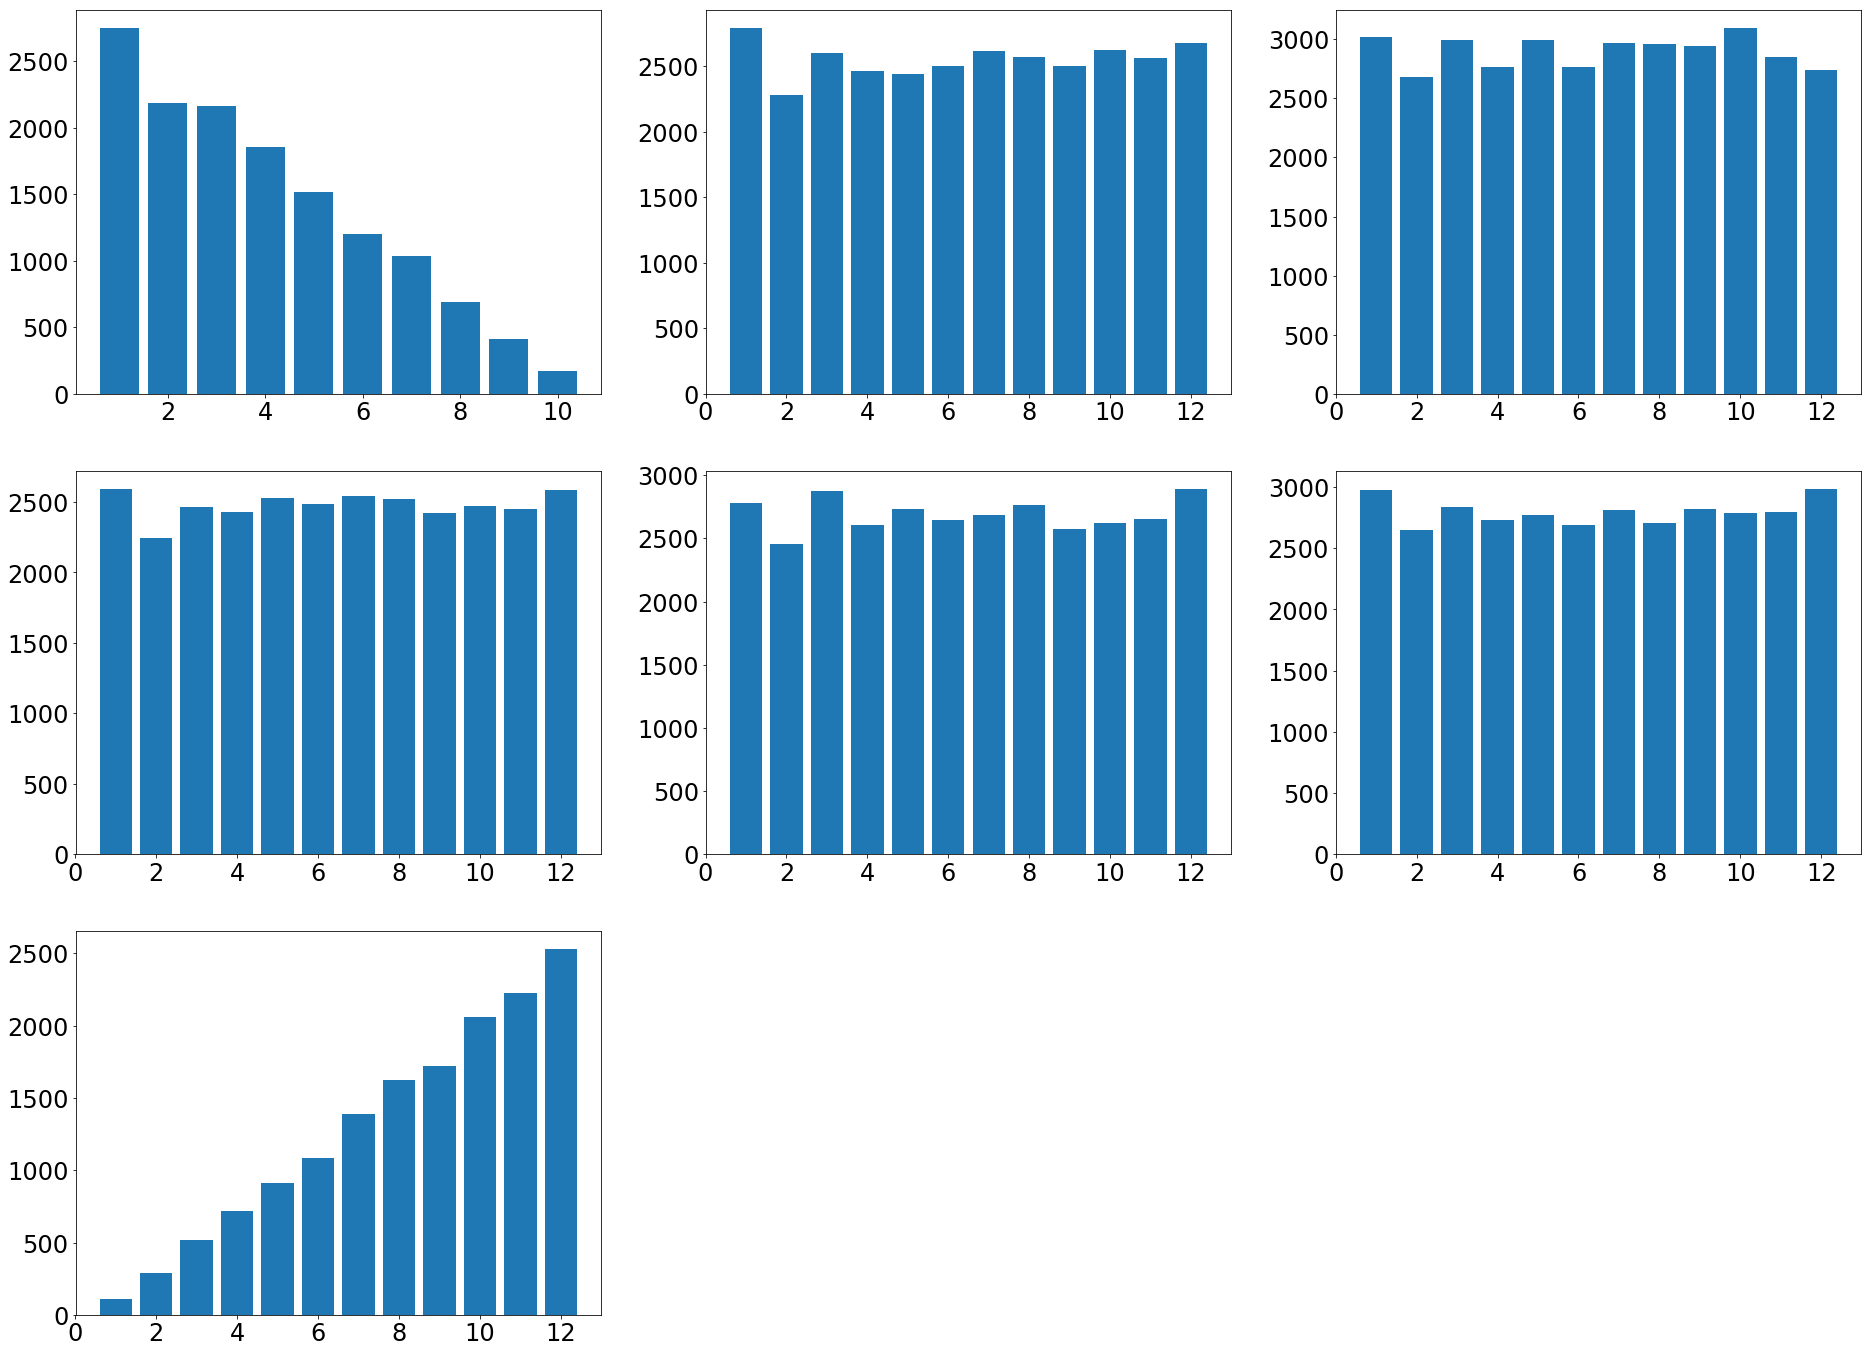

In [115]:
fig = plt.figure()
plotId = 0
keys = list(regulars.keys())
for key in keys:
    charting = []
    plotId = plotId + 1
    for k in regulars[key]:
        admissions = instances(k, key)
        maxes = []
        for a in admissions:
            maxes.append(toDate(a).month)
        charting.append(max(maxes,key=maxes.count))
    ax = fig.add_subplot( 3, 3, plotId )
    bins=collections.Counter(charting)
    ax.bar(list(bins.keys()), list(bins.values()))
        
plt.show()

# Hour Based Time Analysis

## Aggregated Entry Times

Gets the entry hour of each of the frequent flyers' admissions (per year) , then plots every one on the chart. Idea is to find any trends in the months that frequent flyers enter.

In [119]:
def toHour(k):
    return datetime.strptime(k[7][11:19], '%H:%M:%S')

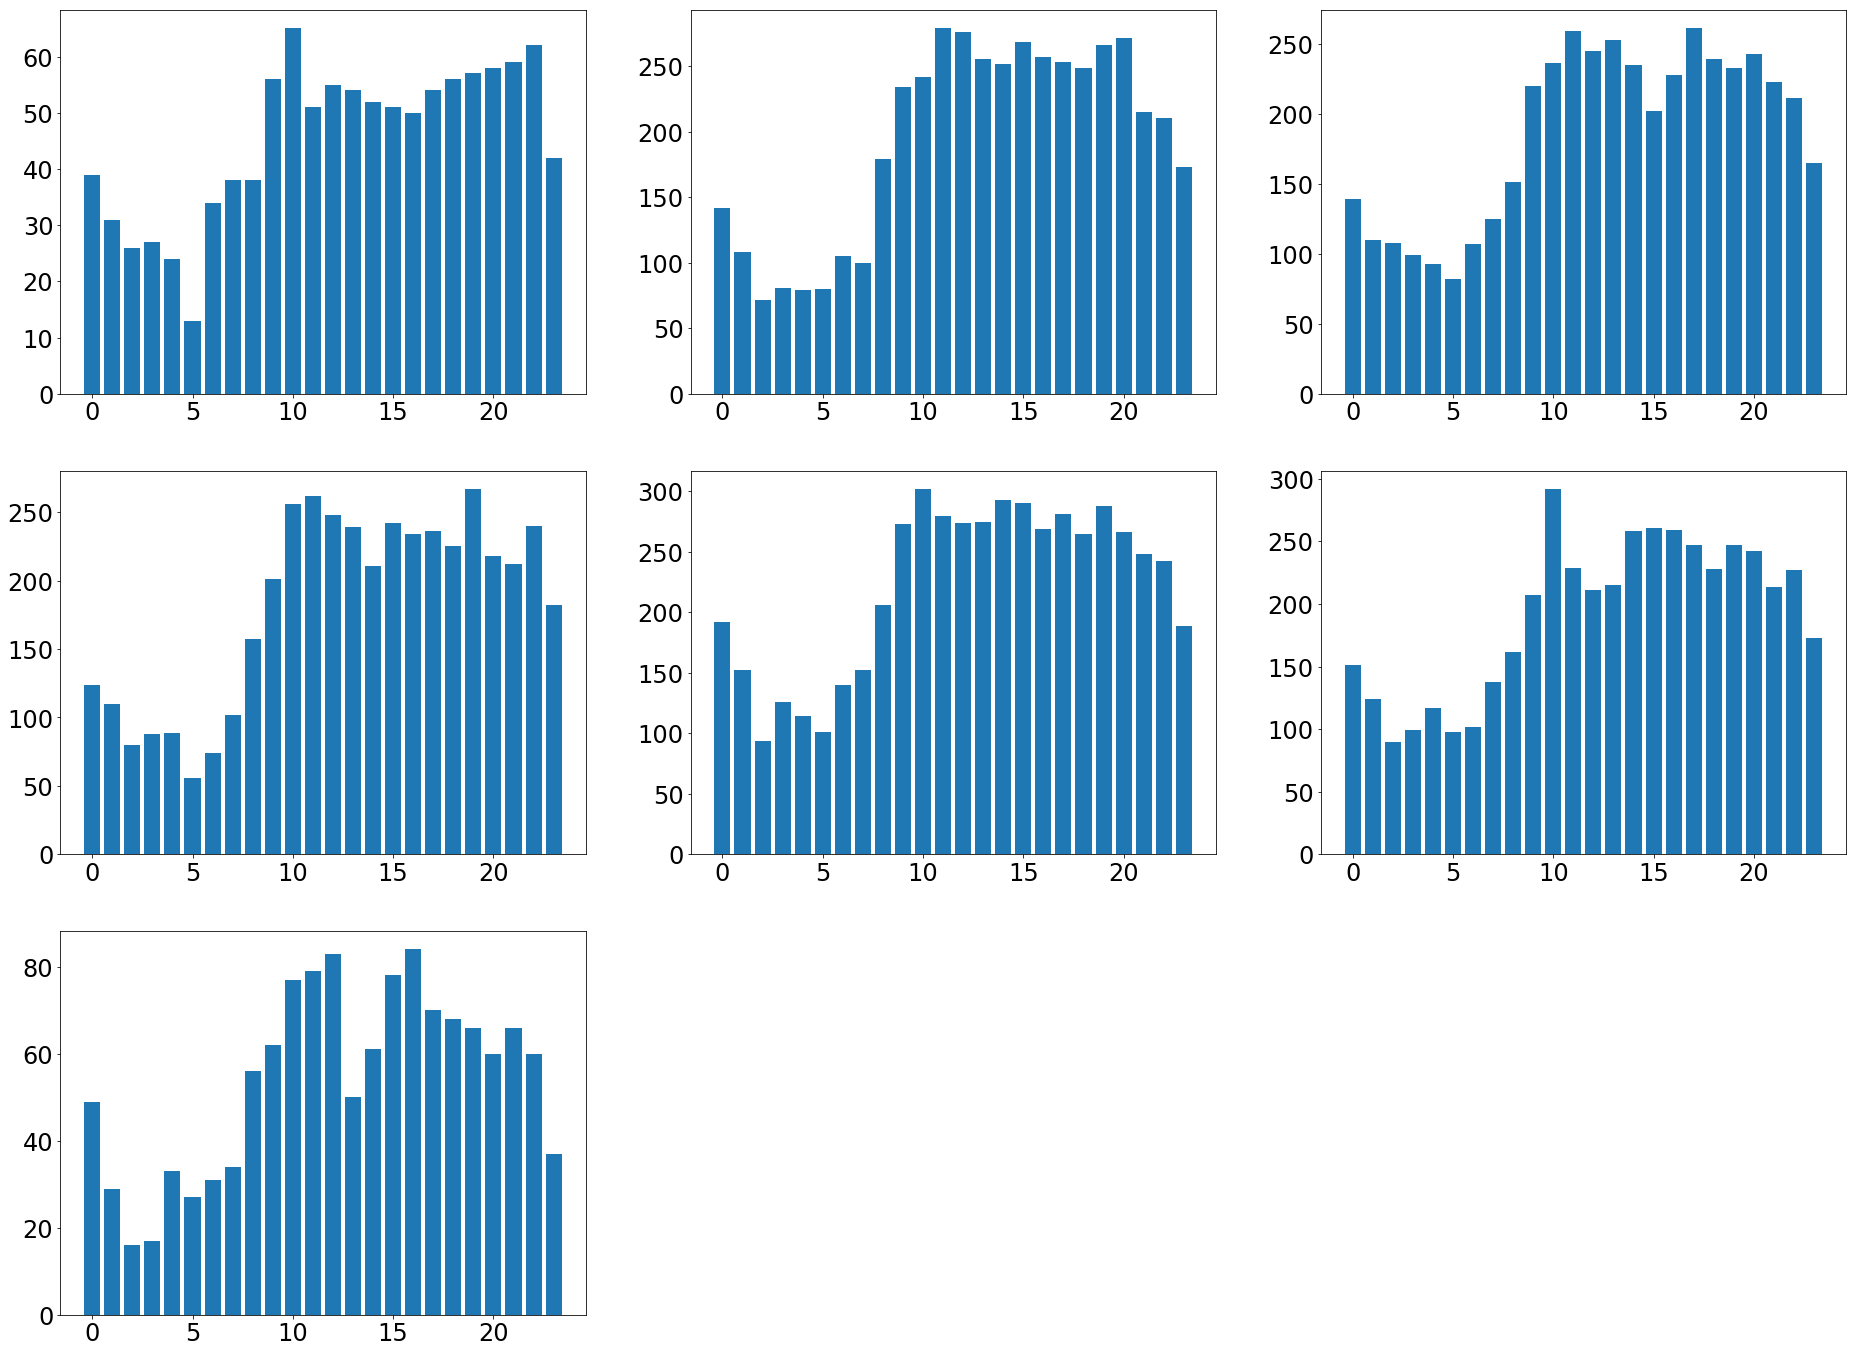

In [120]:
fig = plt.figure()
plotId = 0
keys = list(frequents.keys())
for key in keys:
    charting = []
    plotId = plotId + 1
    for k in frequents[key]:
        admissions = instances(k, key)
        for a in admissions:
            charting.append(toHour(a).hour)
    ax = fig.add_subplot( 3, 3, plotId )
    bins=collections.Counter(charting)
    ax.bar(list(bins.keys()), list(bins.values()))
        
plt.show()

Same but repeated for the regular cohort

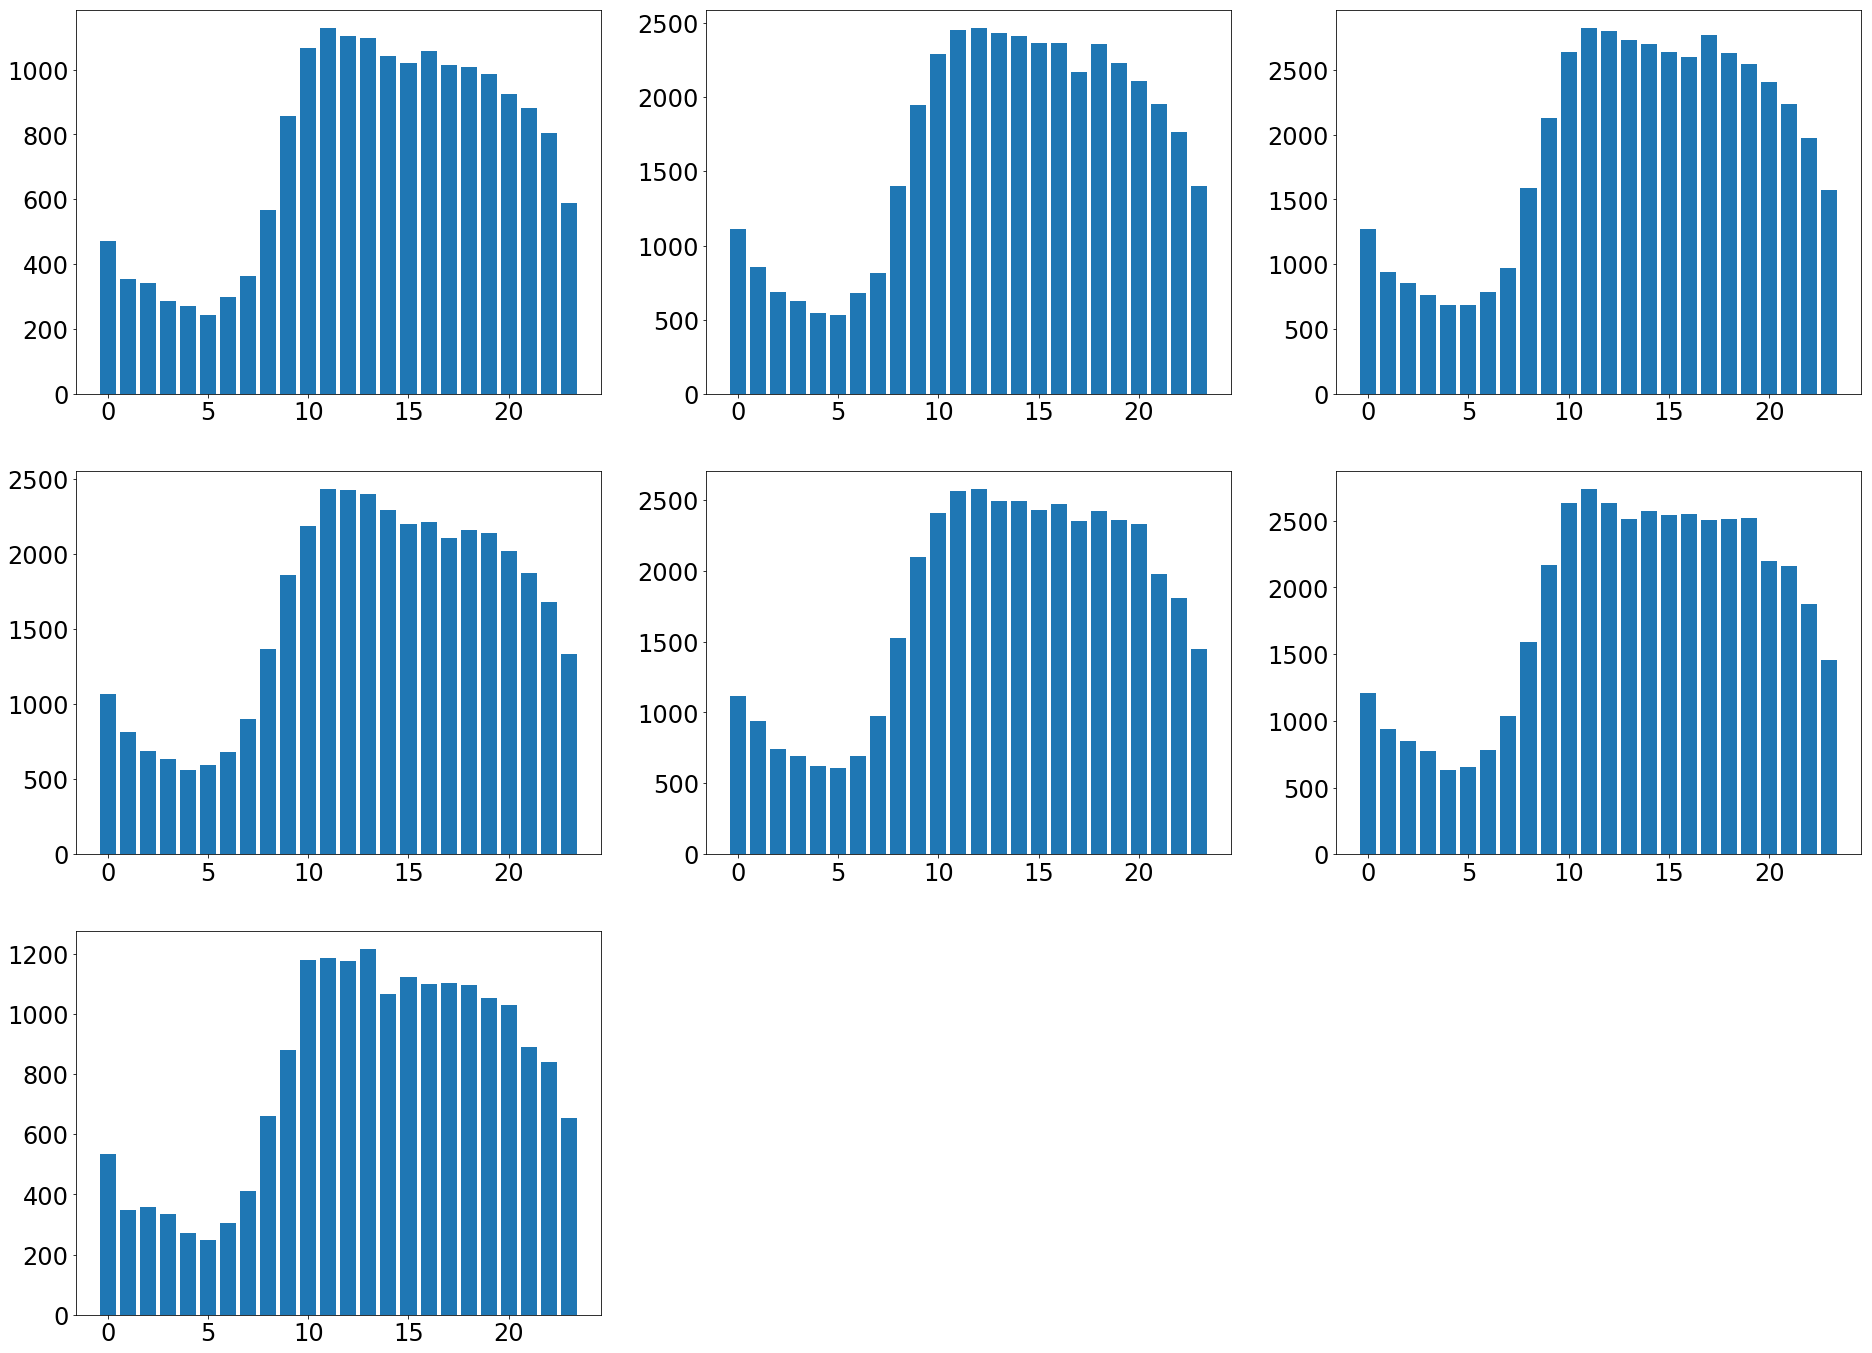

In [122]:
fig = plt.figure()
plotId = 0
keys = list(regulars.keys())
for key in keys:
    charting = []
    plotId = plotId + 1
    for k in regulars[key]:
        admissions = instances(k, key)
        for a in admissions:
            charting.append(toHour(a).hour)
    ax = fig.add_subplot( 3, 3, plotId )
    bins=collections.Counter(charting)
    ax.bar(list(bins.keys()), list(bins.values()))
        
plt.show()

## Most common hour 

This function will analyse the entry times of frequent flyers, get their most common hour across the year years, and plot the max hour of the frequent flyers

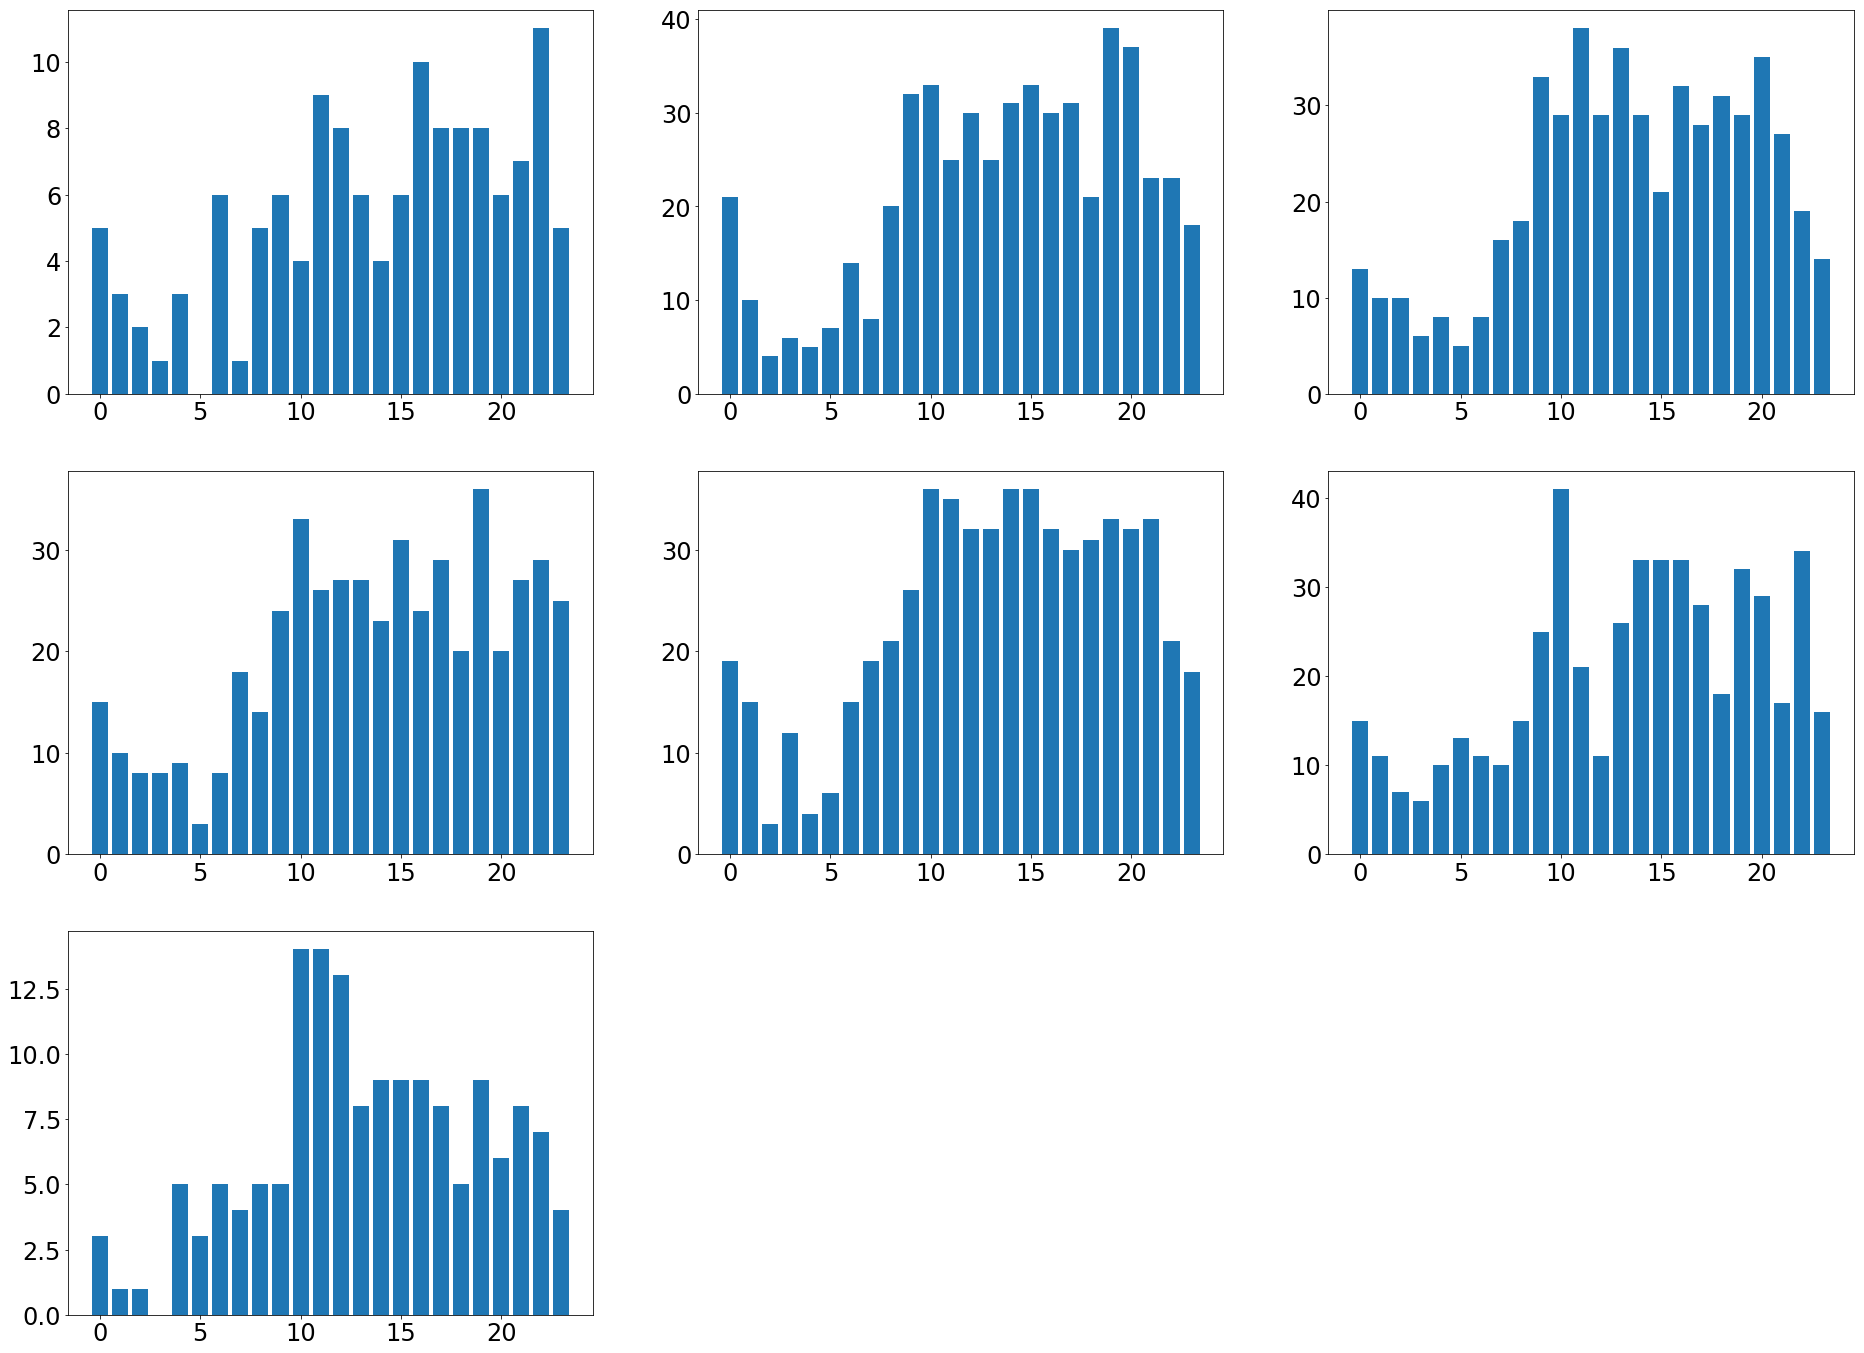

In [123]:
fig = plt.figure()
plotId = 0
keys = list(frequents.keys())
for key in keys:
    charting = []
    plotId = plotId + 1
    for k in frequents[key]:
        admissions = instances(k, key)
        maxes = []
        for a in admissions:
            maxes.append(toHour(a).hour)
        charting.append(max(maxes,key=maxes.count))
    ax = fig.add_subplot( 3, 3, plotId )
    bins=collections.Counter(charting)
    ax.bar(list(bins.keys()), list(bins.values()))
        
plt.show()

Same but repeated for the regular cohort

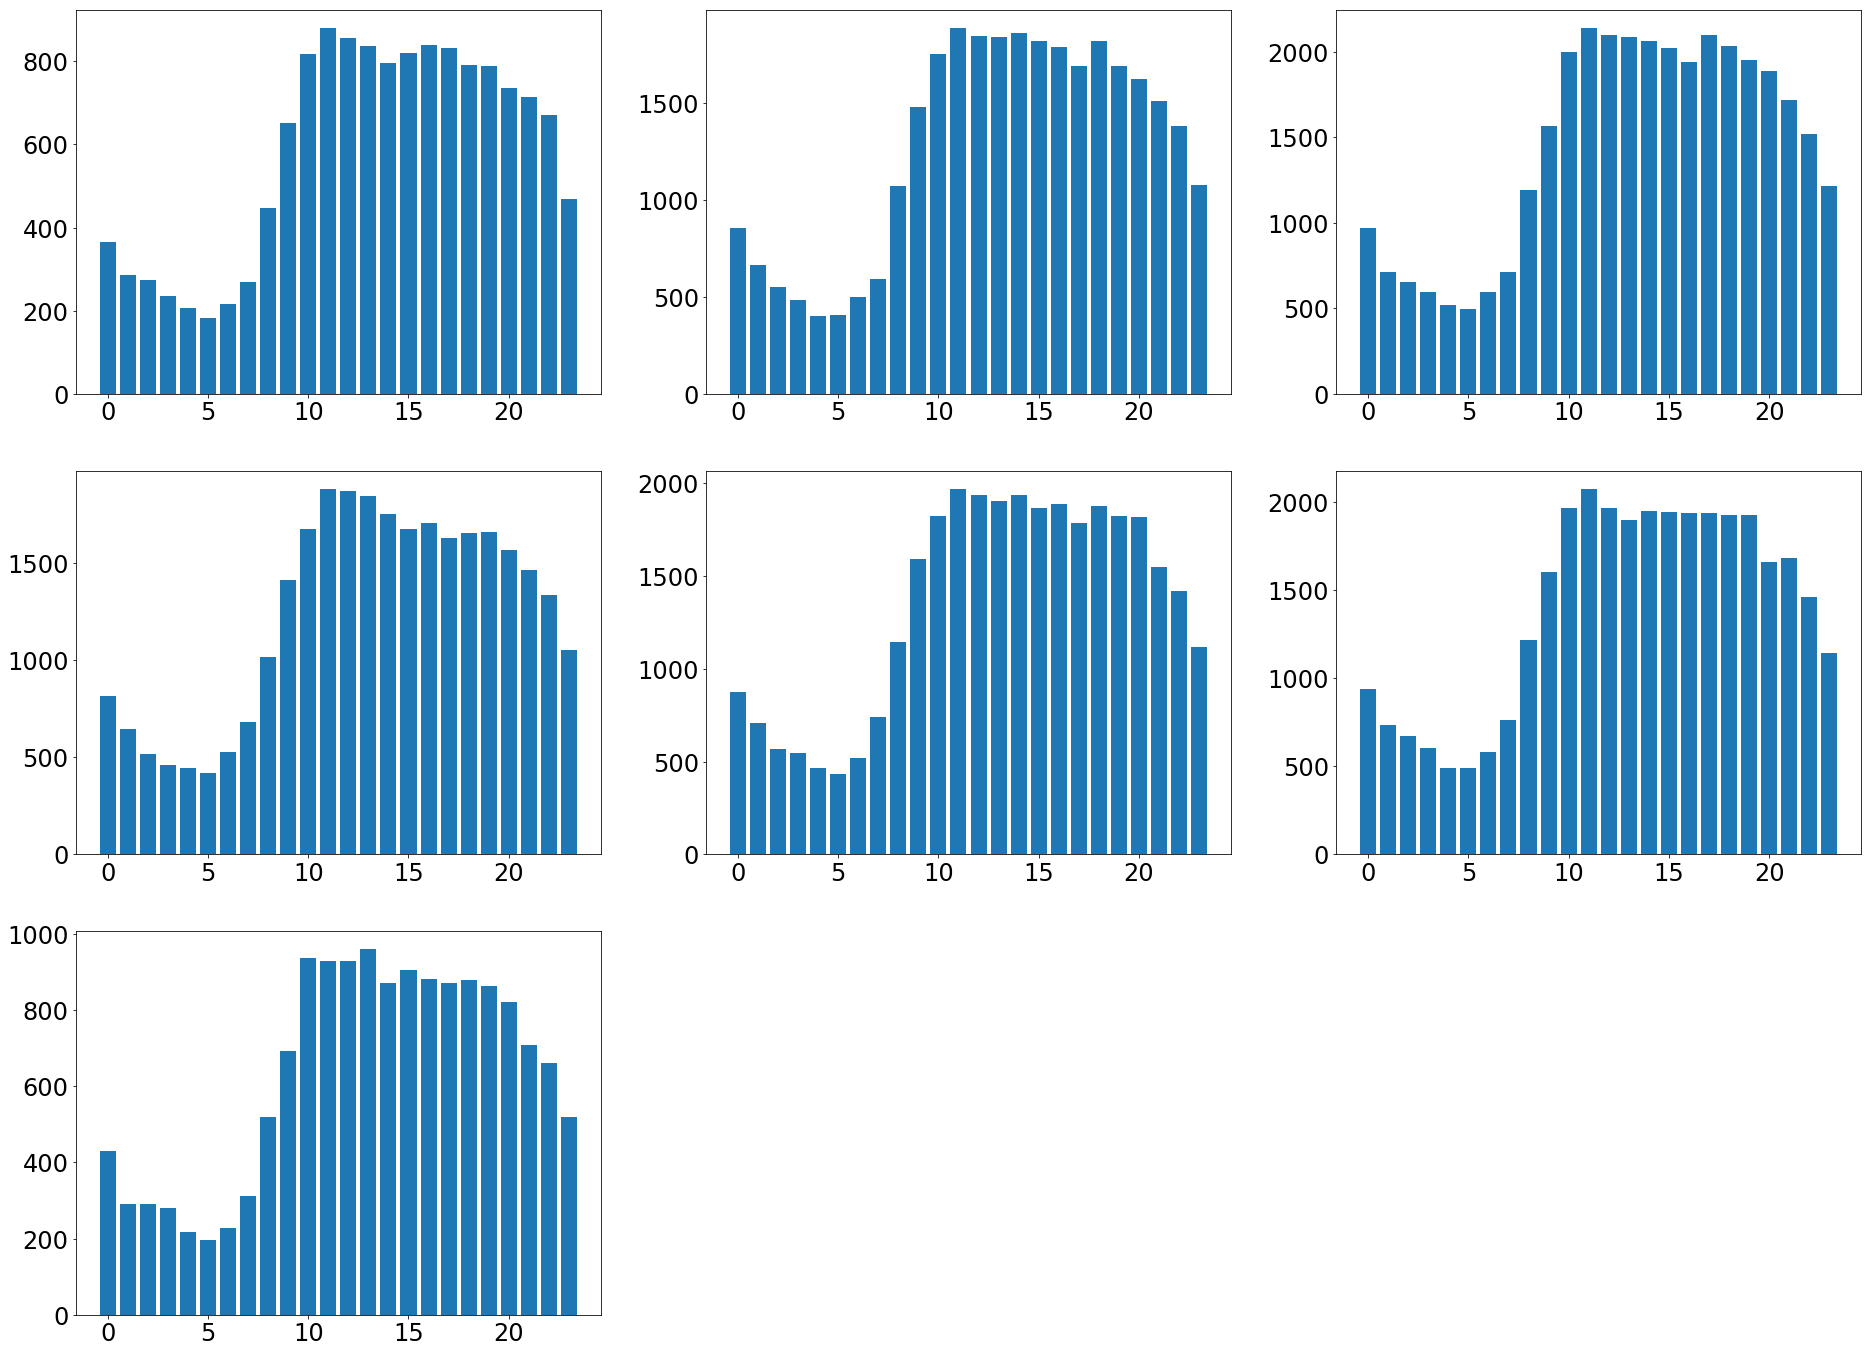

In [124]:
fig = plt.figure()
plotId = 0
keys = list(regulars.keys())
for key in keys:
    charting = []
    plotId = plotId + 1
    for k in regulars[key]:
        admissions = instances(k, key)
        maxes = []
        for a in admissions:
            maxes.append(toHour(a).hour)
        charting.append(max(maxes,key=maxes.count))
    ax = fig.add_subplot( 3, 3, plotId )
    bins=collections.Counter(charting)
    ax.bar(list(bins.keys()), list(bins.values()))
        
plt.show()

# Prescriptions Analysis

We wanted to have a look at whether a reason explaining frequent flyers was a receval of more medication from the hospital on each visit.

In [17]:
organisedPrescriptions = organisePrescriptions(prescriptions[1:])

In [18]:
import numpy as np
import math

#this function calculates the ratio of times the patients of a year were given medication
def getMedRatios(dataIds, year):
    nearestTen = []
    ratiosFreq = []
    for patient in dataIds:
        given = []
        admissions = instances(patient, year)
        visitIds = [item[0] for item in admissions]
        for a in visitIds:
            if (a in organisedPrescriptions[year]):
                given.append(a)
        nearestTen.append(math.floor((len(given)/len(admissions))*10)*10)
        ratiosFreq.append(len(given)/len(admissions))
    
    return (nearestTen, ratiosFreq, np.mean(ratiosFreq))

### Analysis on Percentage Received

Below is an analysis, per year, of the percentage of times that a frequent flyer will get medication compared to a regular patient. The figures show the distribution of percentages across both the frequent flyer and the regular patient cohort.

-----------------
Average for year 2018 is:
0.410118258565
-----------------
-----------------
Average for year 2014 is:
0.541791693575
-----------------
-----------------
Average for year 2017 is:
0.451610606793
-----------------
-----------------
Average for year 2013 is:
0.497164875828
-----------------
-----------------
Average for year 2015 is:
0.507990263131
-----------------
-----------------
Average for year 2016 is:
0.483167739948
-----------------
-----------------
Average for year 2012 is:
0.469024290594
-----------------


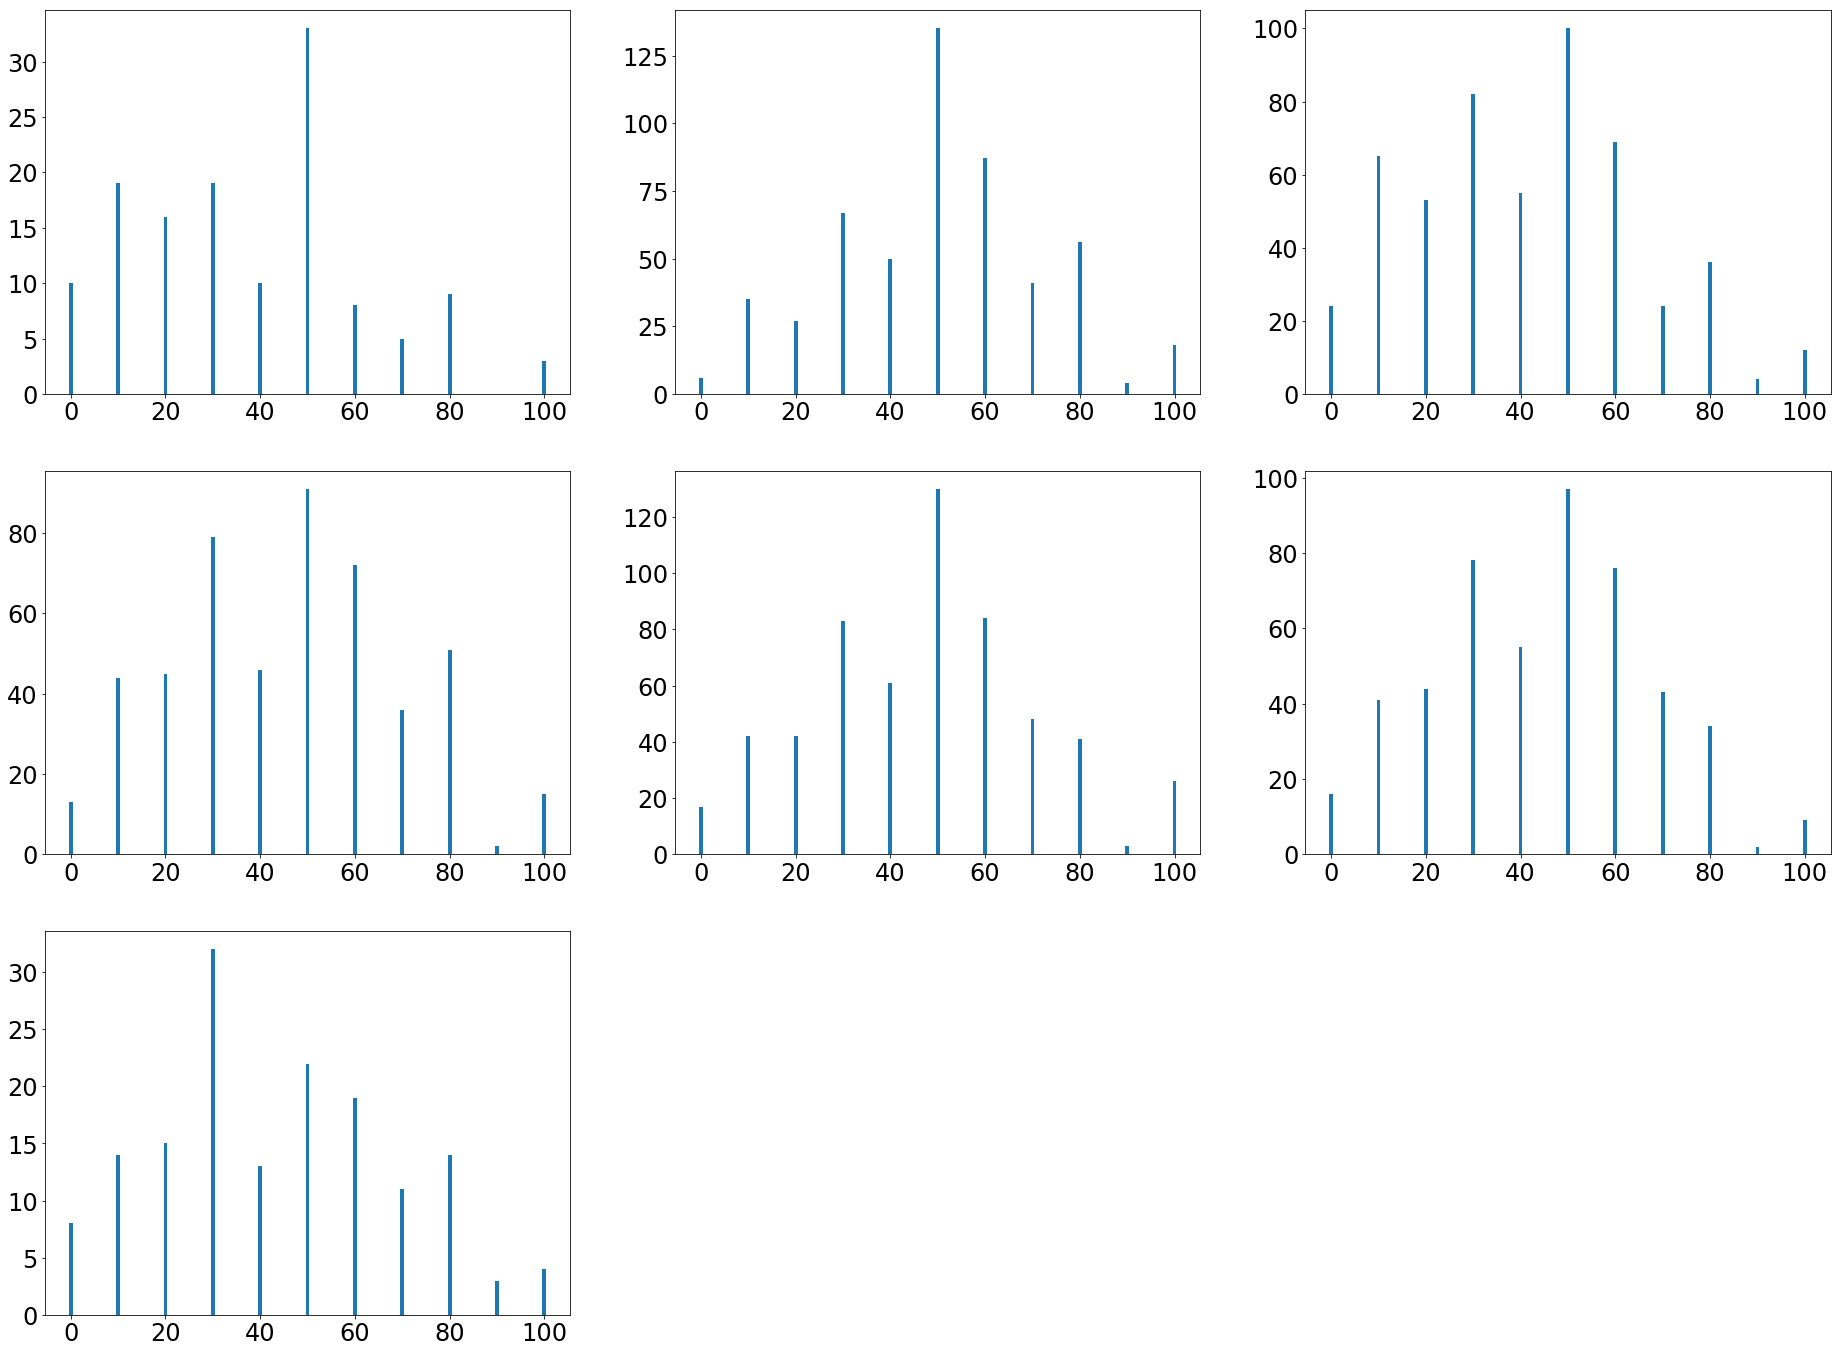

In [87]:

fig = plt.figure()
plotId = 1
keys = list(frequents.keys())
for key in keys:
    ratios = (getMedRatios(frequents[key], key))
    print("-----------------")
    print("Average for year "+ key + " is:")
    print(ratios[2])
    print("-----------------")
    ax = fig.add_subplot( 3, 3, plotId )
    bins=collections.Counter(ratios[0])
    ax.bar(list(bins.keys()), list(bins.values()))
    plotId = plotId + 1
plt.show()


The same, but repeated for the normal cohort

-----------------
Average for year 2018 is:
0.504574391989
-----------------
-----------------
Average for year 2014 is:
0.573135051558
-----------------
-----------------
Average for year 2017 is:
0.529866344513
-----------------
-----------------
Average for year 2013 is:
0.54777307063
-----------------
-----------------
Average for year 2015 is:
0.568152254708
-----------------
-----------------
Average for year 2016 is:
0.564700768077
-----------------
-----------------
Average for year 2012 is:
0.552266341806
-----------------


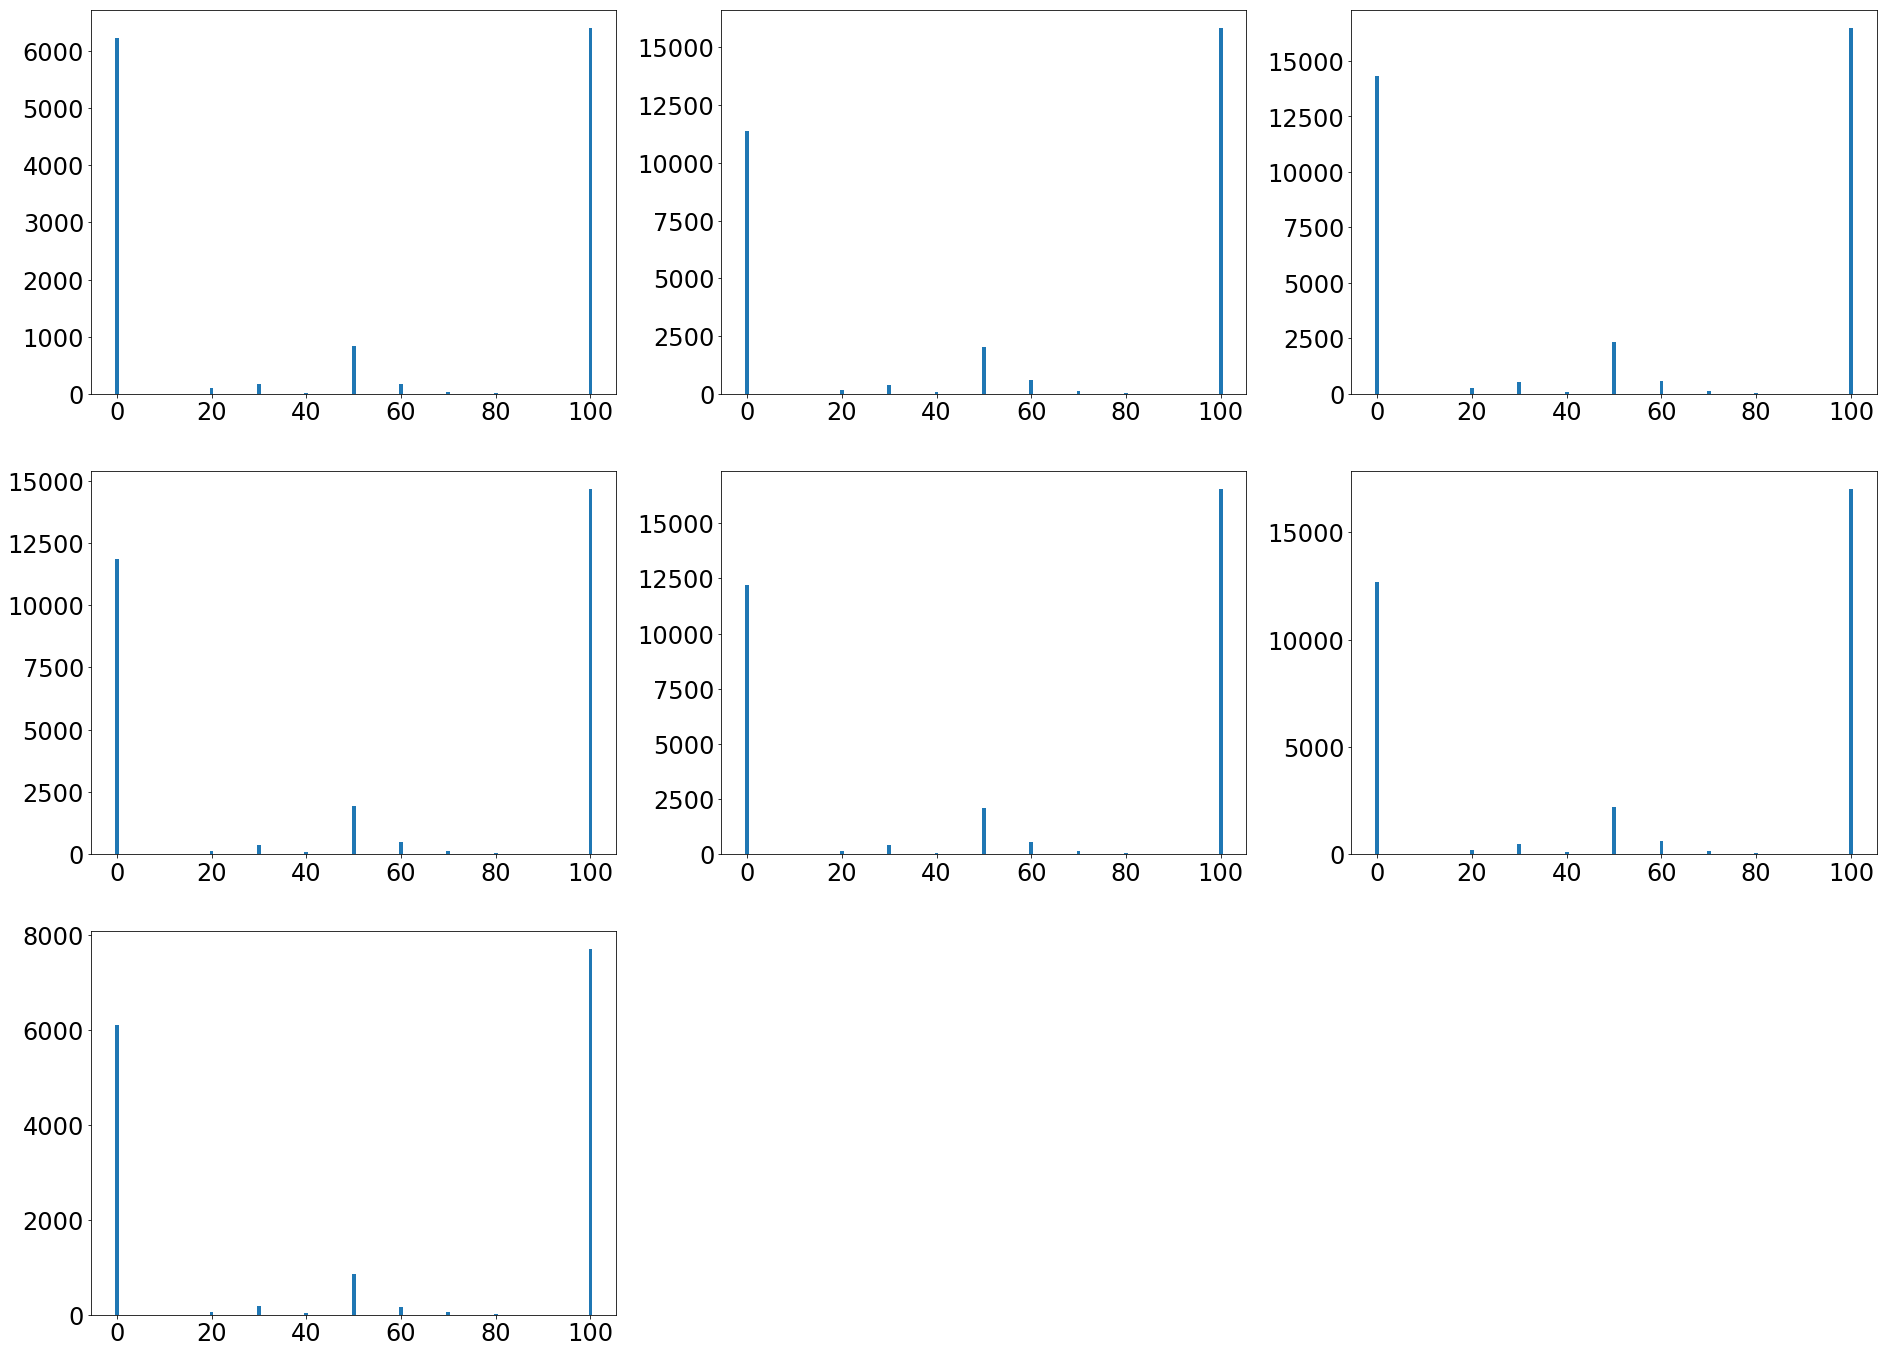

In [88]:

fig = plt.figure()
plotId = 1
keys = list(regulars.keys())
for key in keys:
    ratios = (getMedRatios(regulars[key], key))
    print("-----------------")
    print("Average for year "+ key + " is:")
    print(ratios[2])
    print("-----------------")
    ax = fig.add_subplot( 3, 3, plotId )
    bins=collections.Counter(ratios[0])
    ax.bar(list(bins.keys()), list(bins.values()))
    plotId = plotId + 1
plt.show()


### Admission gap

An analysis on the number of days it takes for a patient to come in again both after getting medication and not getting any medicaiton

In [119]:
#average gap when I got something
#average gap when I didn't
from datetime import datetime
import math
import numpy as np

keys = list(frequents.keys())

for key in keys:
    patientAvLengthsGiven = []
    patientAvLengthsNotGiven = []

    for patient in frequents[key]:
        lengthsGiven = []
        lengthsNotGiven = []
        admissions = instances(patient, key)
        admissions = [(item[0],datetime.strptime(item[7][0:10], '%Y-%m-%d')) for item in admissions]
        admissions = sorted(admissions, key=lambda x: x[1])
        for k,a in enumerate(admissions[:-1]):
            if (a[0] in organisedPrescriptions[key]):
                lengthsGiven.append(abs(a[1]-admissions[k+1][1]))
            else:
                lengthsNotGiven.append(abs(a[1]-admissions[k+1][1]))
        if (len(lengthsGiven)>0):
            patientAvLengthsGiven.append(np.mean(lengthsGiven))
        if (len(lengthsNotGiven)>0):
            patientAvLengthsNotGiven.append(np.mean(lengthsNotGiven))
    
    print("Data for " + key)
    print("Average number of days until next visit when:")
    print("----------")
    print("Given medication:")
    print(np.mean(patientAvLengthsGiven))
    print("----------")
    print("Not given medication:")
    print(np.mean(patientAvLengthsNotGiven))
    print("                     ")


Data for 2018
Average number of days until next visit when:
----------
Given medication:
21 days, 14:53:59.304170
----------
Not given medication:
23 days, 15:17:57.696054
                     
Data for 2014
Average number of days until next visit when:
----------
Given medication:
32 days, 19:20:33.620022
----------
Not given medication:
33 days, 8:49:21.460850
                     
Data for 2017
Average number of days until next visit when:
----------
Given medication:
32 days, 17:28:16.757264
----------
Not given medication:
33 days, 1:45:33.267329
                     
Data for 2013
Average number of days until next visit when:
----------
Given medication:
31 days, 21:40:40.798580
----------
Not given medication:
33 days, 4:18:50.300594
                     
Data for 2015
Average number of days until next visit when:
----------
Given medication:
30 days, 17:52:45.374917
----------
Not given medication:
32 days, 18:31:21.469268
                     
Data for 2016
Average number of d

Same again but for regular patients

In [120]:
#average gap when I got something
#average gap when I didn't
from datetime import datetime
import math
import numpy as np

keys = list(regulars.keys())

for key in keys:
    patientAvLengthsGiven = []
    patientAvLengthsNotGiven = []

    for patient in regulars[key]:
        lengthsGiven = []
        lengthsNotGiven = []
        admissions = instances(patient, key)
        admissions = [(item[0],datetime.strptime(item[7][0:10], '%Y-%m-%d')) for item in admissions]
        admissions = sorted(admissions, key=lambda x: x[1])
        for k,a in enumerate(admissions[:-1]):
            if (a[0] in organisedPrescriptions[key]):
                lengthsGiven.append(abs(a[1]-admissions[k+1][1]))
            else:
                lengthsNotGiven.append(abs(a[1]-admissions[k+1][1]))
        if (len(lengthsGiven)>0):
            patientAvLengthsGiven.append(np.mean(lengthsGiven))
        if (len(lengthsNotGiven)>0):
            patientAvLengthsNotGiven.append(np.mean(lengthsNotGiven))
    
    print("Data for " + key)
    print("Average number of days until next visit when:")
    print("----------")
    print("Given medication:")
    print(np.mean(patientAvLengthsGiven))
    print("----------")
    print("Not given medication:")
    print(np.mean(patientAvLengthsNotGiven))
    print("                     ")


Data for 2018
Average number of days until next visit when:
----------
Given medication:
38 days, 17:31:31.200000
----------
Not given medication:
41 days, 1:55:35.294118
                     
Data for 2014
Average number of days until next visit when:
----------
Given medication:
61 days, 14:10:13.900167
----------
Not given medication:
63 days, 2:08:22.111324
                     
Data for 2017
Average number of days until next visit when:
----------
Given medication:
67 days, 23:17:35.390009
----------
Not given medication:
65 days, 2:30:19.800000
                     
Data for 2013
Average number of days until next visit when:
----------
Given medication:
63 days, 12:54:07.494217
----------
Not given medication:
64 days, 14:39:31.428571
                     
Data for 2015
Average number of days until next visit when:
----------
Given medication:
63 days, 18:30:40.750057
----------
Not given medication:
65 days, 6:26:17.904533
                     
Data for 2016
Average number of da

# Chronic Frequent Flyers

In [19]:
print("There are " + str(len(chronic)) + " chronic frequent flyers in the data set")

There are 2 chronic frequent flyers in the data set


## Machine Learning on Data

Will do 5 fold cross validation to see if, using our metrics, we can detect a frequent flyer

### Getting the biggest data set

In [20]:
lengths = []
for key in frequents:
    lengths.append((key, len(frequents[key])))
lengths = sorted(lengths, key=lambda x: x[1])[::-1]
print(lengths)
print(str(lengths[0][0]) + " has the biggest data set available")

[('2015', 577), ('2014', 526), ('2017', 524), ('2016', 495), ('2013', 494), ('2012', 155), ('2018', 132)]
2015 has the biggest data set available


# Using the time and prescription distance metics in a SVM to see if we can predict a frequent flyer

### We will be using the other years to predict the 2018 data set. The features are formed based on prescription values; one feature corresponds to the average time between admissions, and the other will 

In [21]:
def difference(l1,l2):
    return len([b for a,b in zip(l1,l2) if b != a])

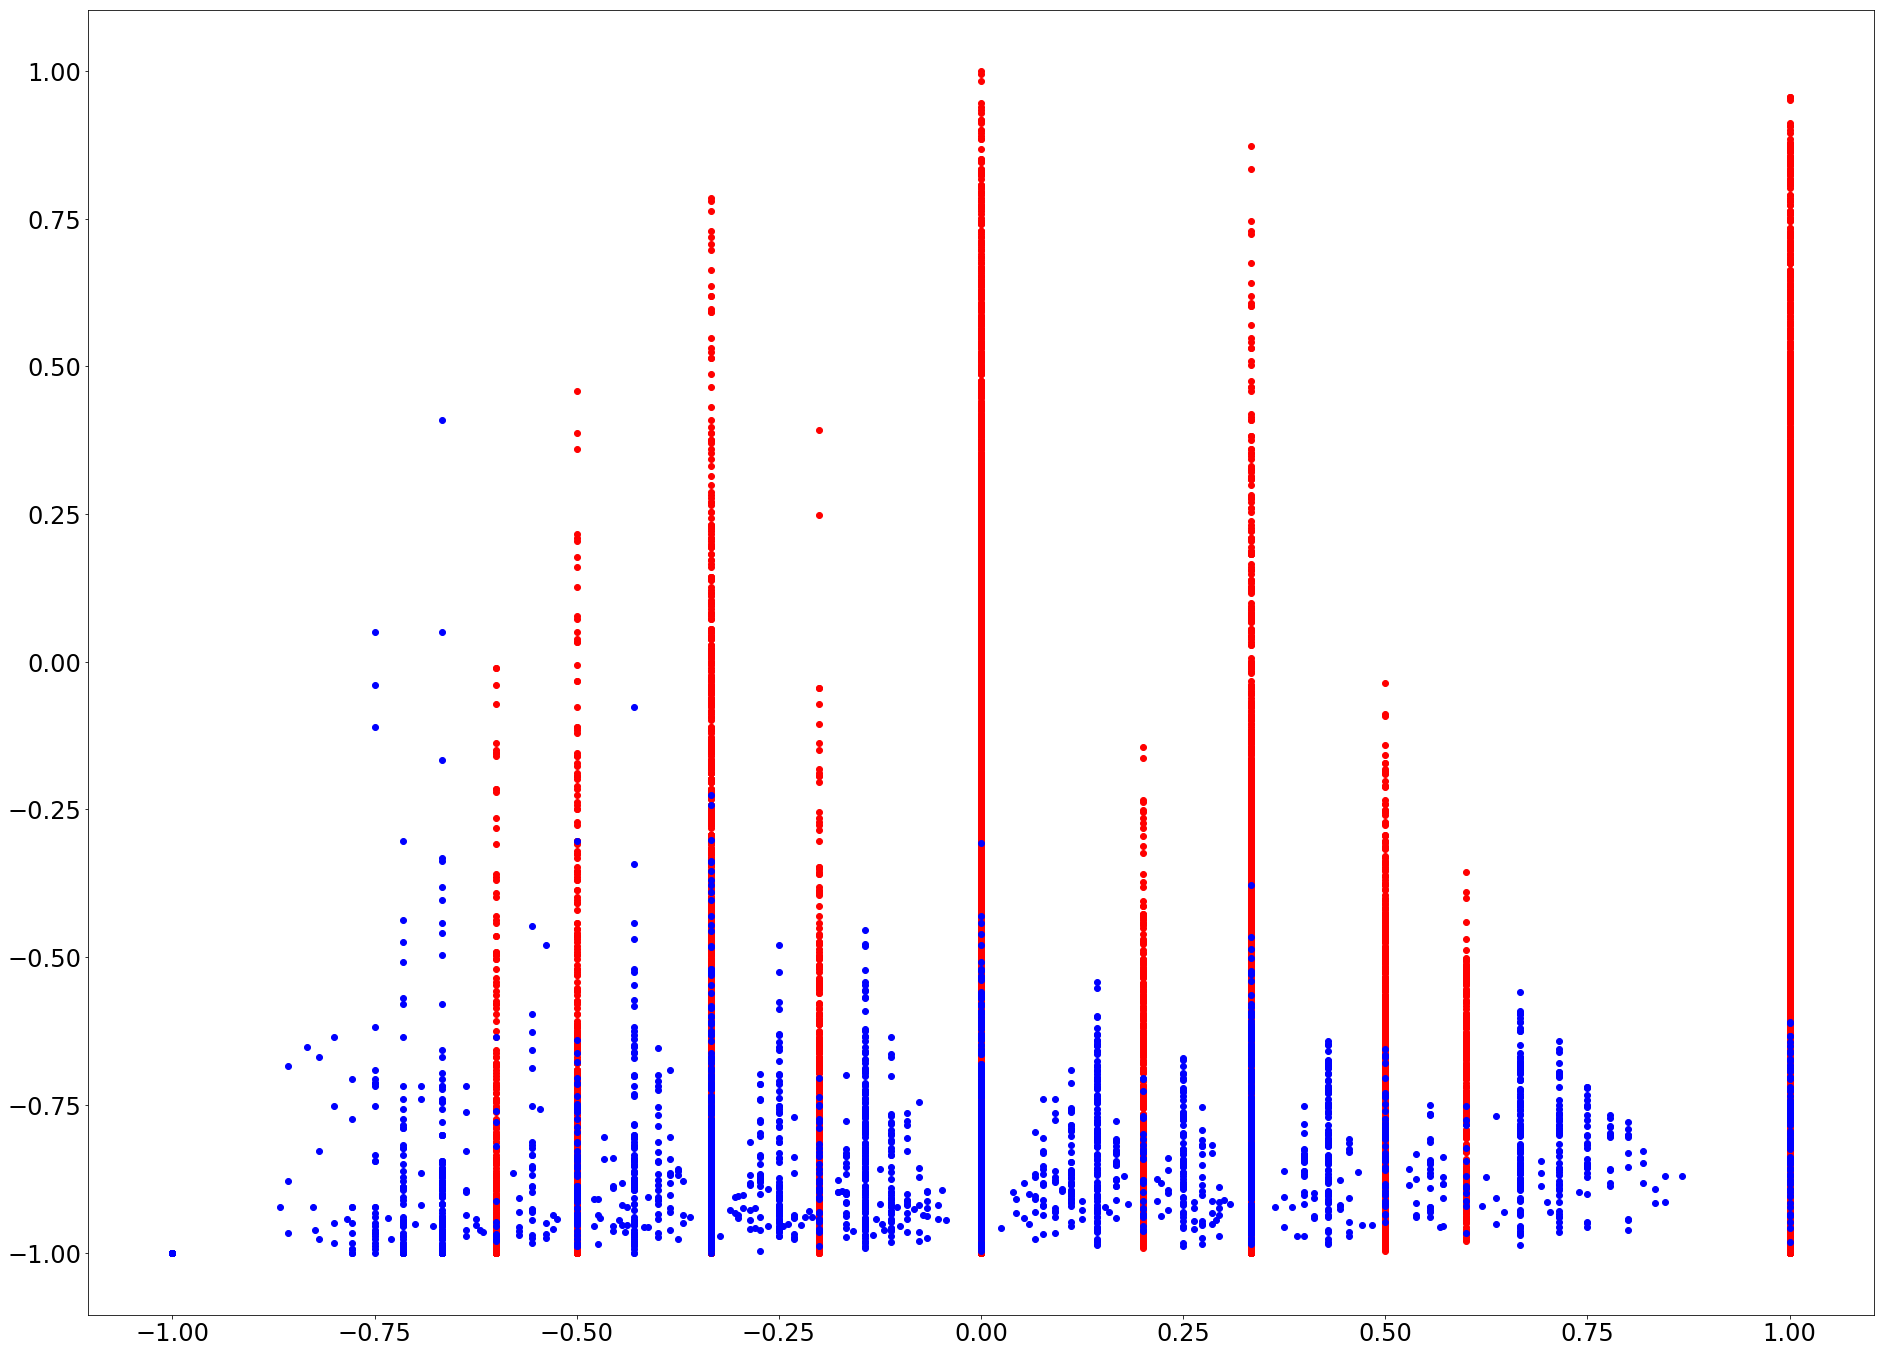

In [22]:
from sklearn.model_selection import KFold
from sklearn import svm
import numpy as np
from sklearn.preprocessing import MinMaxScaler

#calculates the average time difference in days between times a dosage was given and when they next came back
#this function does it for the frequent flyers
def distanceBetweenDose(key):
    retVal = []
    for patient in frequents[key]:
        lengthsGiven = []
        admissions = instances(patient, key)
        admissions = [(item[0],datetime.strptime(item[7][0:10], '%Y-%m-%d')) for item in admissions]
        admissions = sorted(admissions, key=lambda x: x[1])
        for k,a in enumerate(admissions[:-1]):
            if (a[0] in organisedPrescriptions[key]):
                lengthsGiven.append(abs(a[1]-admissions[k+1][1]).days)
        if (len(lengthsGiven)>0):
            retVal.append(np.mean(lengthsGiven))
        else:
            retVal.append(0)
    return retVal

#this function does it for the regular cohort
def distanceBetweenDoseReg(key):
    retVal = []
    for patient in regulars[key]:
        lengthsGiven = []
        admissions = instances(patient, key)
        admissions = [(item[0],datetime.strptime(item[7][0:10], '%Y-%m-%d')) for item in admissions]
        admissions = sorted(admissions, key=lambda x: x[1])
        for k,a in enumerate(admissions[:-1]):
            if (a[0] in organisedPrescriptions[key]):
                lengthsGiven.append(abs(a[1]-admissions[k+1][1]).days)
        if (len(lengthsGiven)>0):
            retVal.append(np.mean(lengthsGiven))
        else:
            retVal.append(0)
    return retVal

Xtr = []
Ytr = []

Xte = []
Yte = []

#get the training set for frequent flyers
keys = [item[0] for item in lengths[:-1]]
for key in keys:
    ratios = (getMedRatios(frequents[key], key))
    freqs = distanceBetweenDose(key)
    for k,i in enumerate(ratios[1]):
        #add the ratio of medication being given and the average time between visits when medication given
        Xtr.append([i, freqs[k]]) 
        Ytr.append(1) #is a frequent flyer
    
#get the training set for regular cohort   
for key in keys:
    ratios = (getMedRatios(regulars[key].keys(), key))
    freqs = distanceBetweenDoseReg(key)
    for k,i in enumerate(ratios[1]):
        Xtr.append([i, freqs[k]])
        Ytr.append(0)

#get the test set for frequent flyers
ratiosTest = (getMedRatios(frequents[keys[-1]], keys[-1]))
freqs = distanceBetweenDose(keys[-1])
for k,i in enumerate(ratiosTest[1]):
    Xte.append([i, freqs[k]])
    Yte.append(1)

#get the test set for regular cohort
ratiosTestRegs = (getMedRatios(regulars[keys[-1]].keys(), keys[-1]))
freqs = distanceBetweenDoseReg(keys[-1])
for k,i in enumerate(ratiosTestRegs[1]):
    Xte.append([i, freqs[k]])
    Yte.append(0)

scaling = MinMaxScaler(feature_range=(-1,1)).fit(Xtr)
Xtr = scaling.transform(Xtr)
Xte = scaling.transform(Xte) 

# notebook
import matplotlib.pylab as pylab
fig = plt.figure()
AS = [Xtr[key] for key in [k for (k,v) in enumerate(Ytr) if v == 0]] #gets Xtr for all indices of regular cohort
BS = [Xtr[key] for key in [k for (k,v) in enumerate(Ytr) if v == 1]] #gets Xtr for all frequent flyers
plt.scatter([item[0] for item in AS], [item[1] for item in AS], c="r")
plt.scatter([item[0] for item in BS], [item[1] for item in BS], c="b")

plt.show()

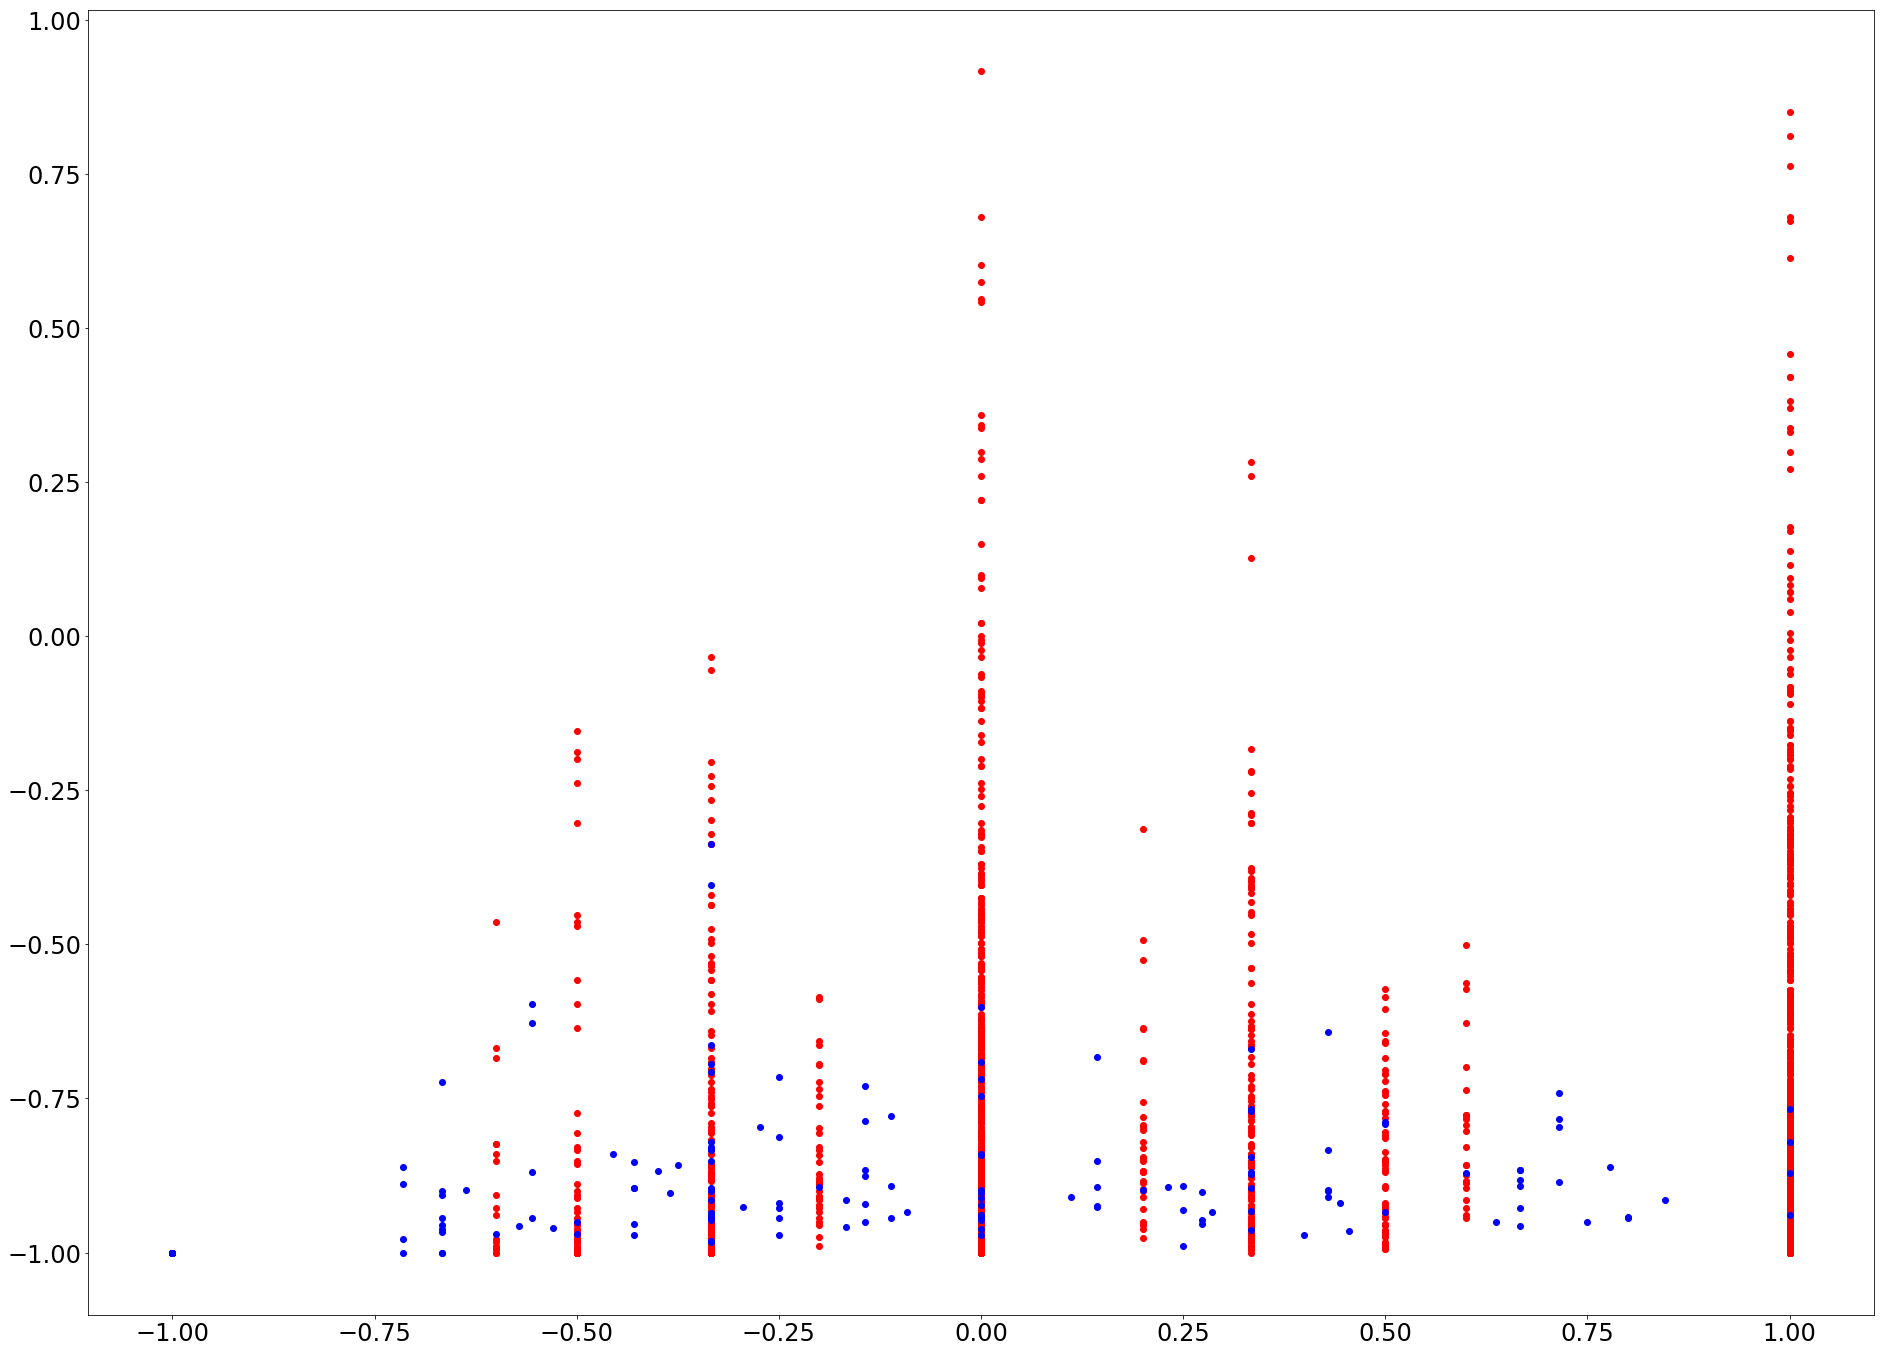

In [23]:
#does same as above but for Xte (the 2018 cohort)
fig = plt.figure()
AS = [Xte[key] for key in [k for (k,v) in enumerate(Yte) if v == 0]]
BS = [Xte[key] for key in [k for (k,v) in enumerate(Yte) if v == 1]]
plt.scatter([item[0] for item in AS], [item[1] for item in AS], c="r")
plt.scatter([item[0] for item in BS], [item[1] for item in BS], c="b")

plt.show()

## Running models on data

The follwing code will run different models on the dataset Xtr, Xte, Ytr, Yte and see's how well we can predict data from it

In [24]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(Xtr, Ytr)
Pred = neigh.predict(Xte)
print(difference(Pred, Yte)/len(Yte))

0.004106642331008409


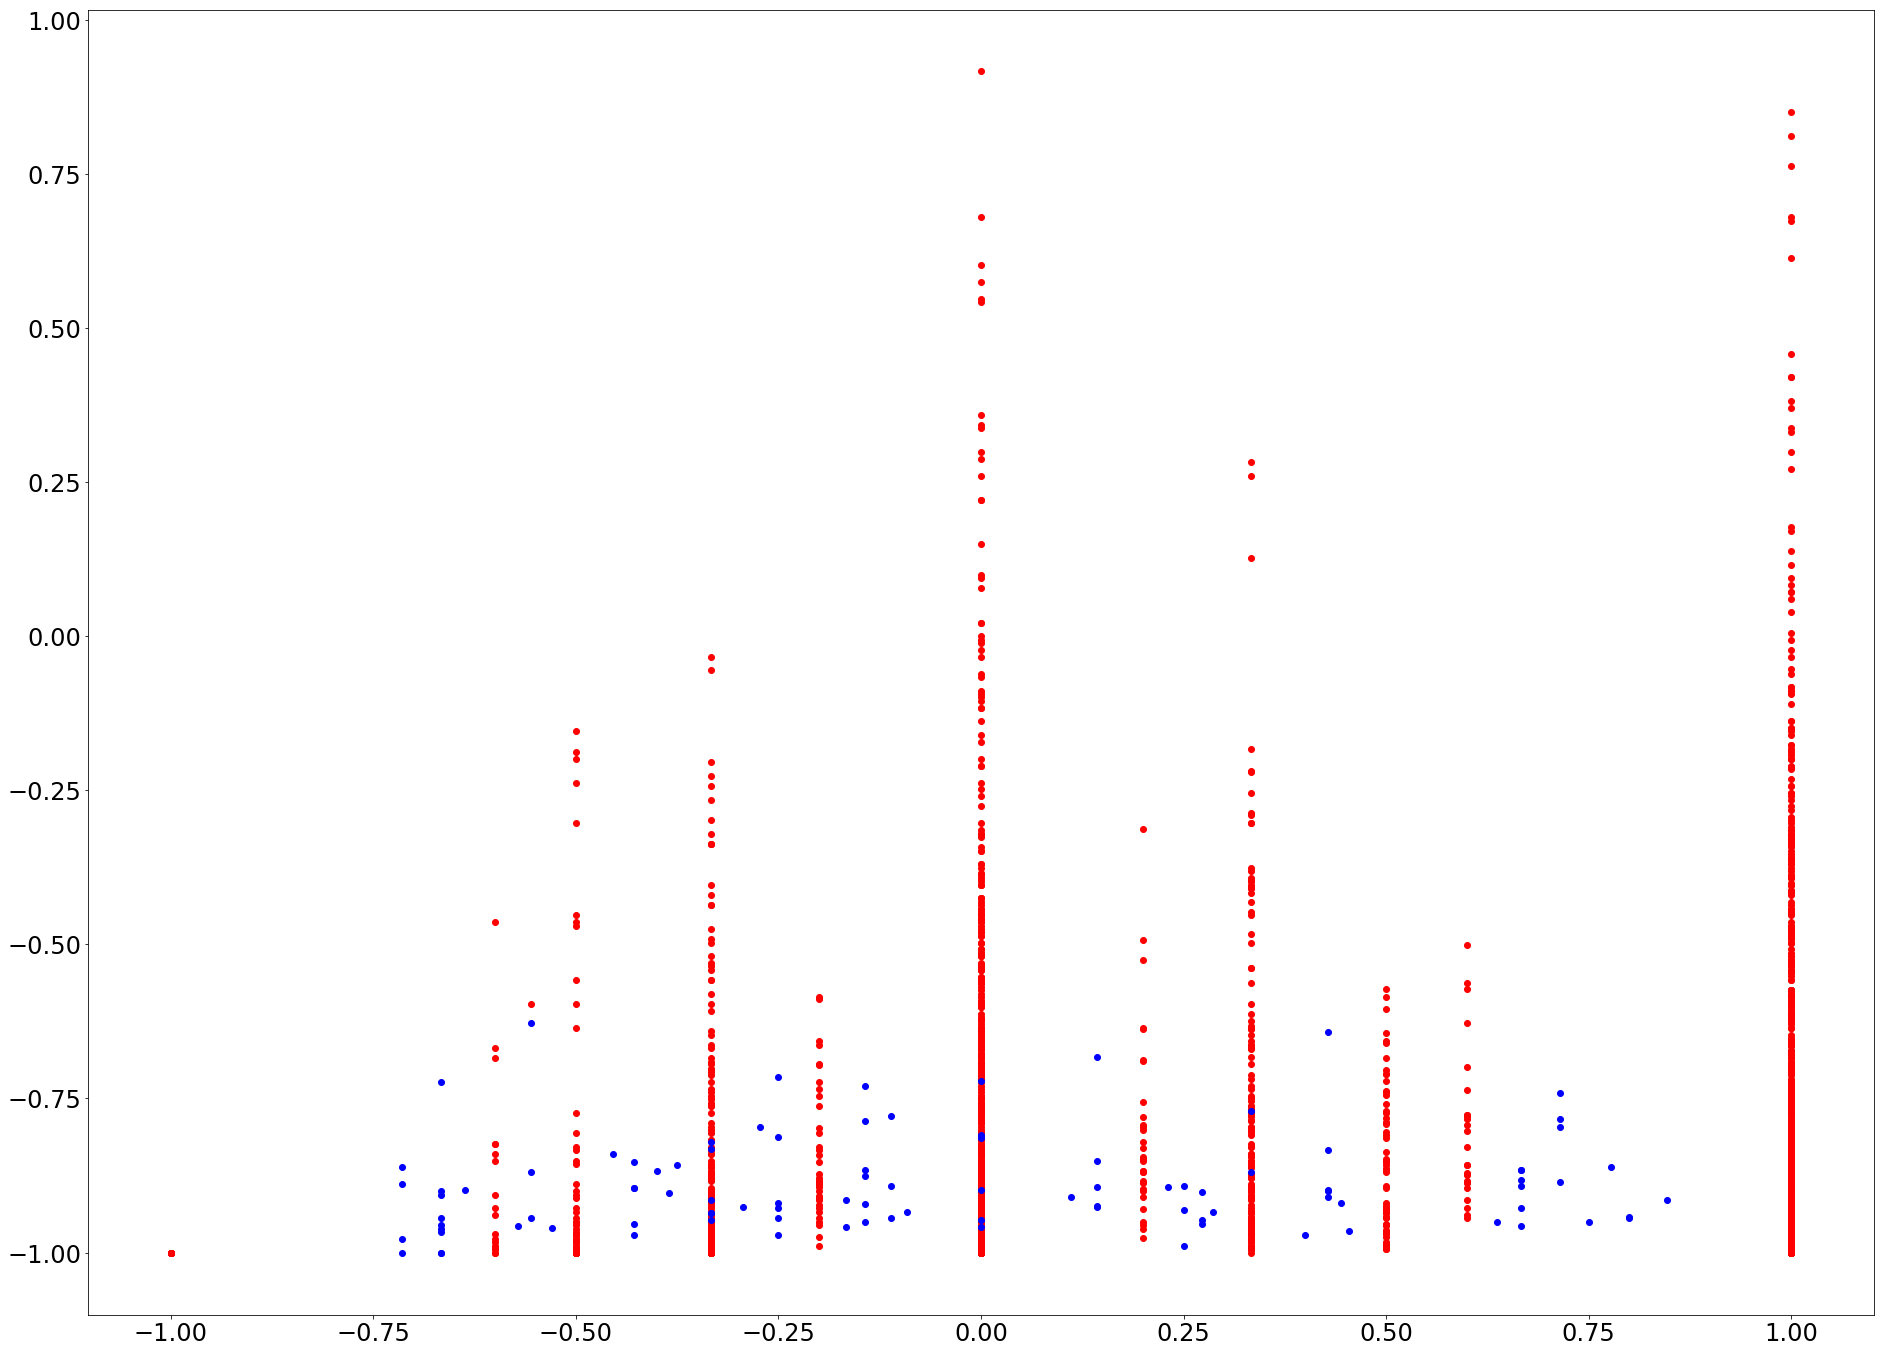

In [25]:
fig = plt.figure()
AS = [Xte[key] for key in [k for (k,v) in enumerate(Pred) if v == 0]]
BS = [Xte[key] for key in [k for (k,v) in enumerate(Pred) if v == 1]]
plt.scatter([item[0] for item in AS], [item[1] for item in AS], c="r")
plt.scatter([item[0] for item in BS], [item[1] for item in BS], c="b")

plt.show()

0.010103643830258784


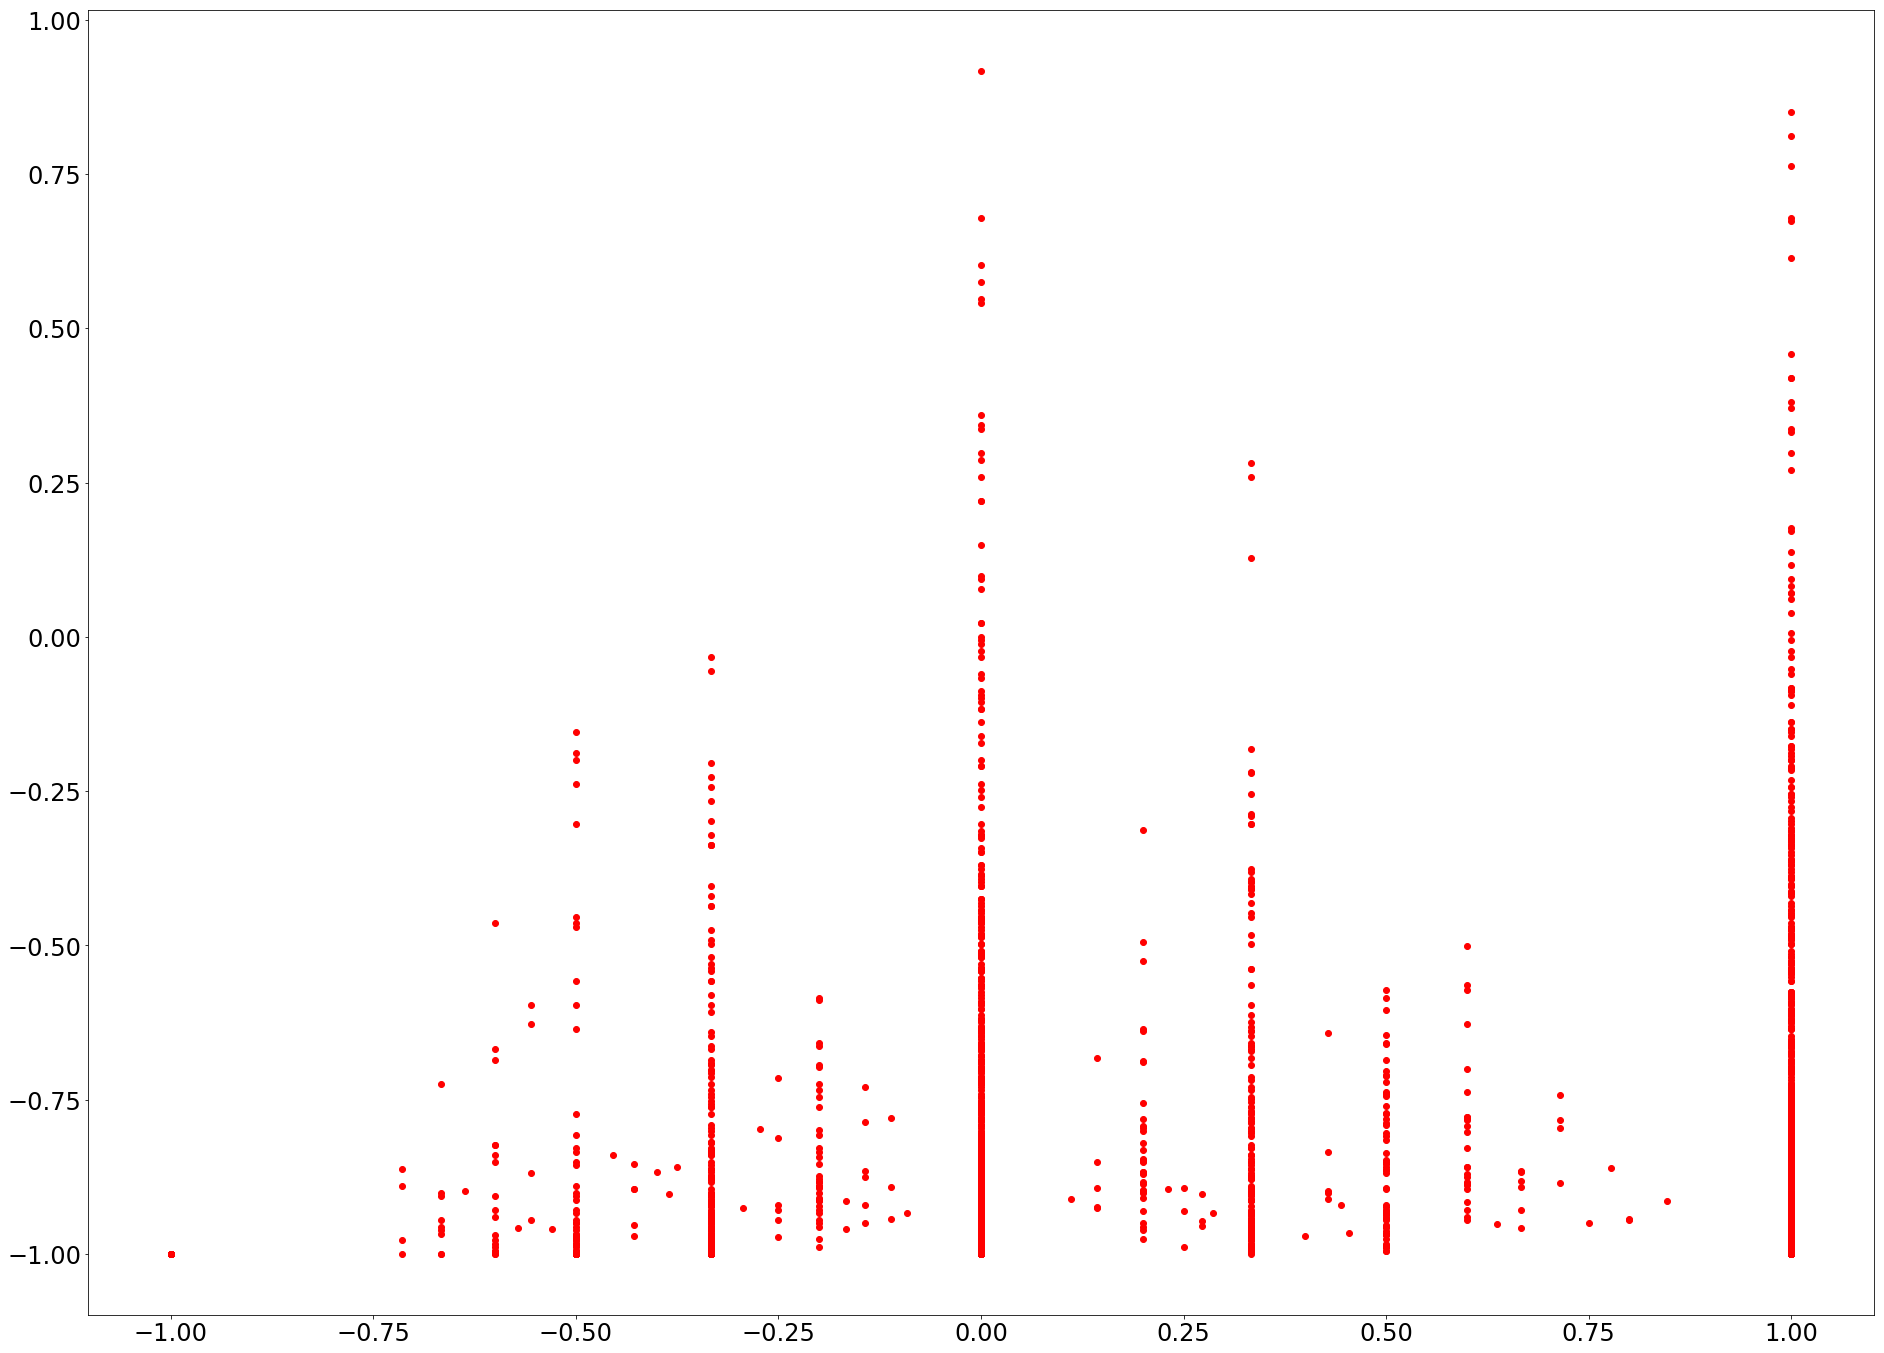

In [26]:
clf = svm.SVC()
clf.fit(Xtr, Ytr) 
Pre = clf.predict(Xte)
print(difference(Yte, Pre)/len(Yte))

fig = plt.figure()
AS = [Xte[key] for key in [k for (k,v) in enumerate(Pre) if v == 0]]
BS = [Xte[key] for key in [k for (k,v) in enumerate(Pre) if v == 1]]
plt.scatter([item[0] for item in AS], [item[1] for item in AS], c="r")
plt.scatter([item[0] for item in BS], [item[1] for item in BS], c="b")

plt.show()

0.010103643830258784


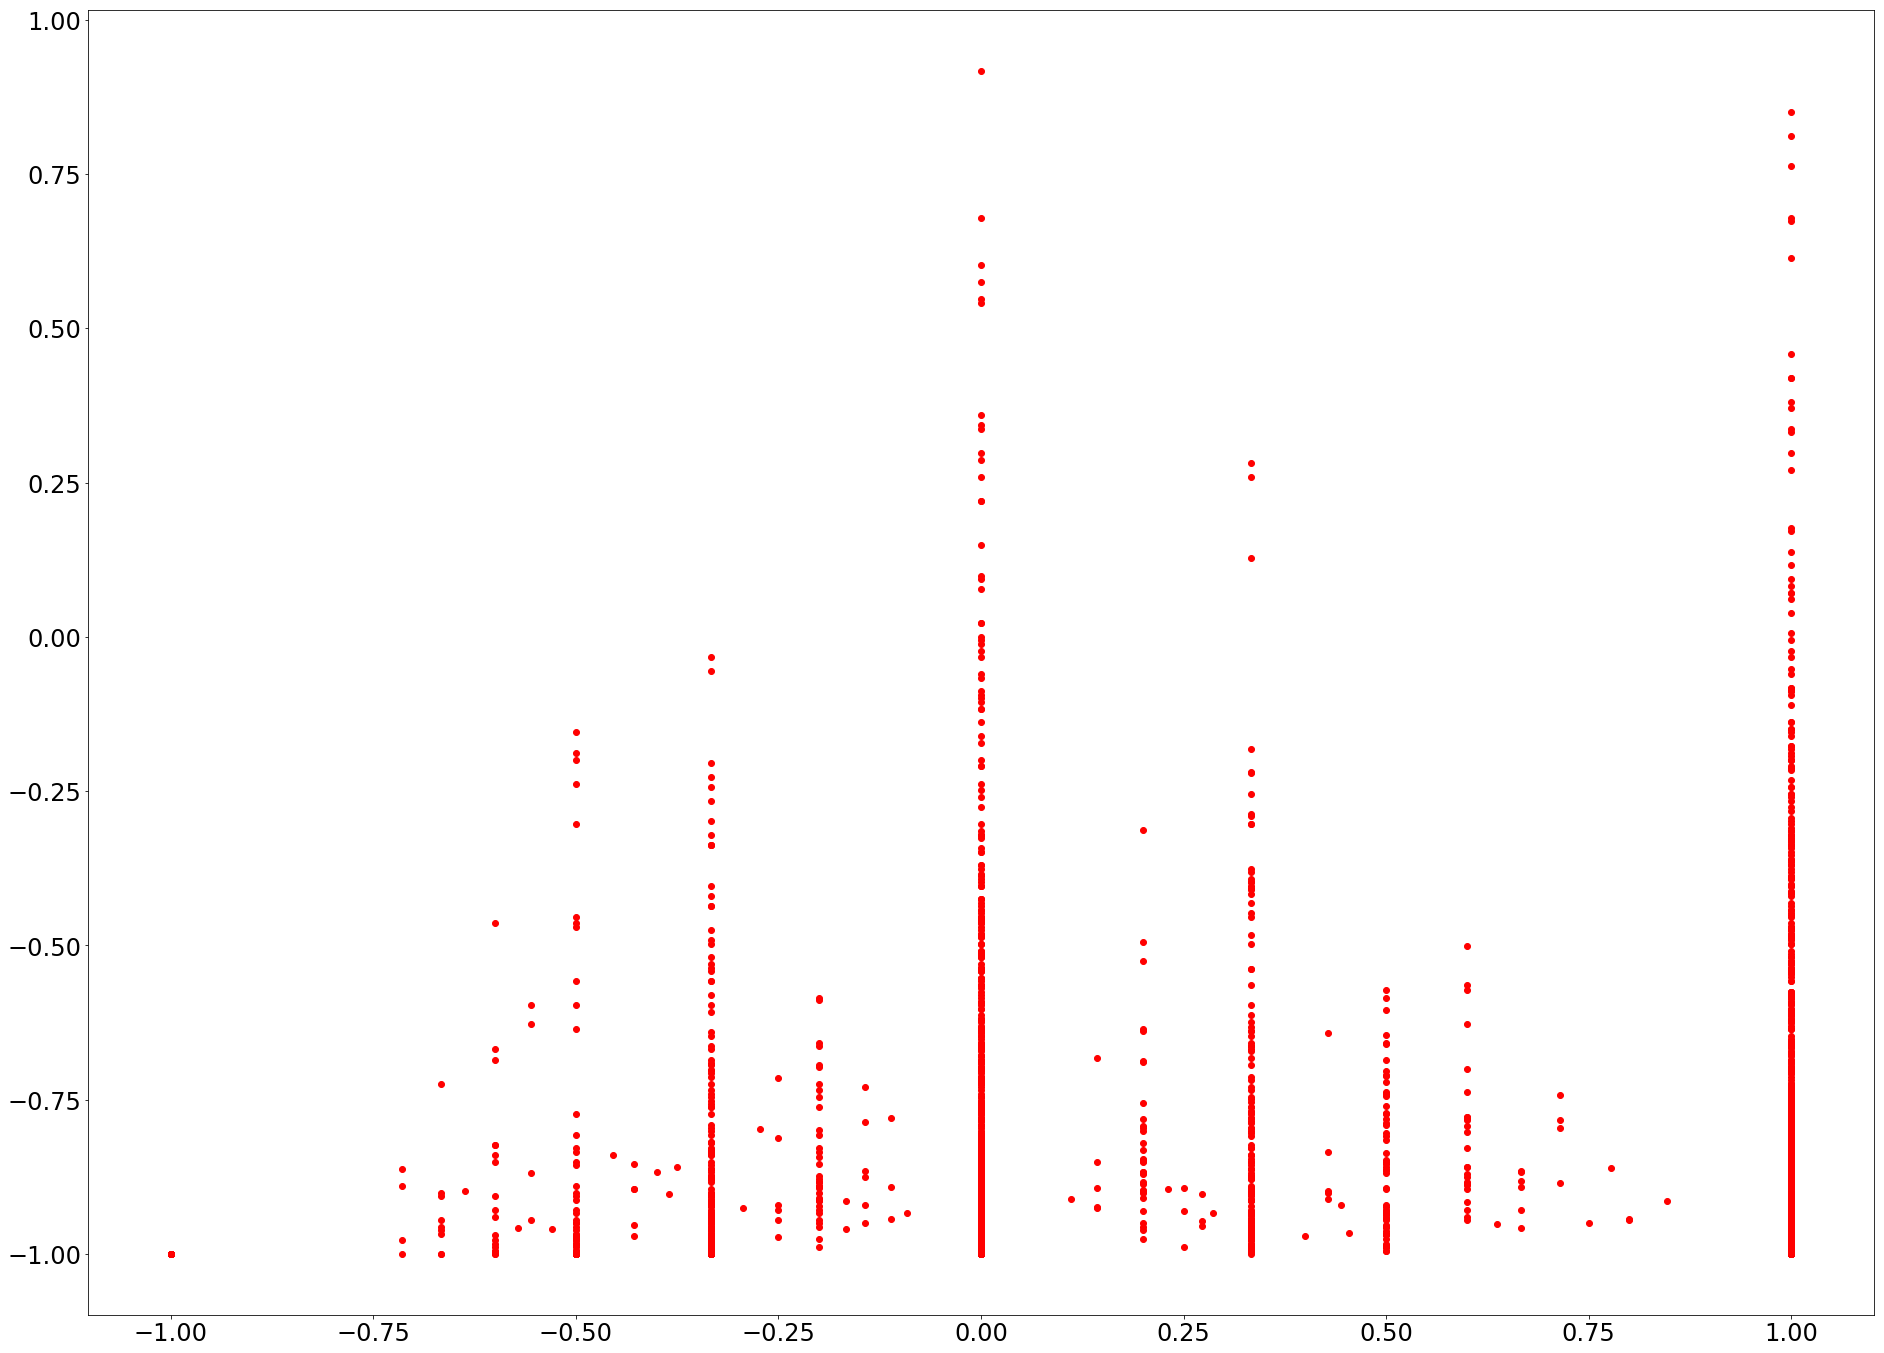

In [27]:
import random

indices = random.sample(range(0, len(Ytr)-1), len(Yte))

newXtr = [Xtr[i] for i in indices]
newYtr = [Ytr[i] for i in indices]

clf = svm.SVC()
clf.fit(newXtr, newYtr) 
Pre2 = clf.predict(Xte)
print(difference(Yte, Pre2)/len(Yte))

fig = plt.figure()
AS = [Xte[key] for key in [k for (k,v) in enumerate(Pre2) if v == 0]]
BS = [Xte[key] for key in [k for (k,v) in enumerate(Pre2) if v == 1]]
plt.scatter([item[0] for item in AS], [item[1] for item in AS], c="r")
plt.scatter([item[0] for item in BS], [item[1] for item in BS], c="b")

plt.show()

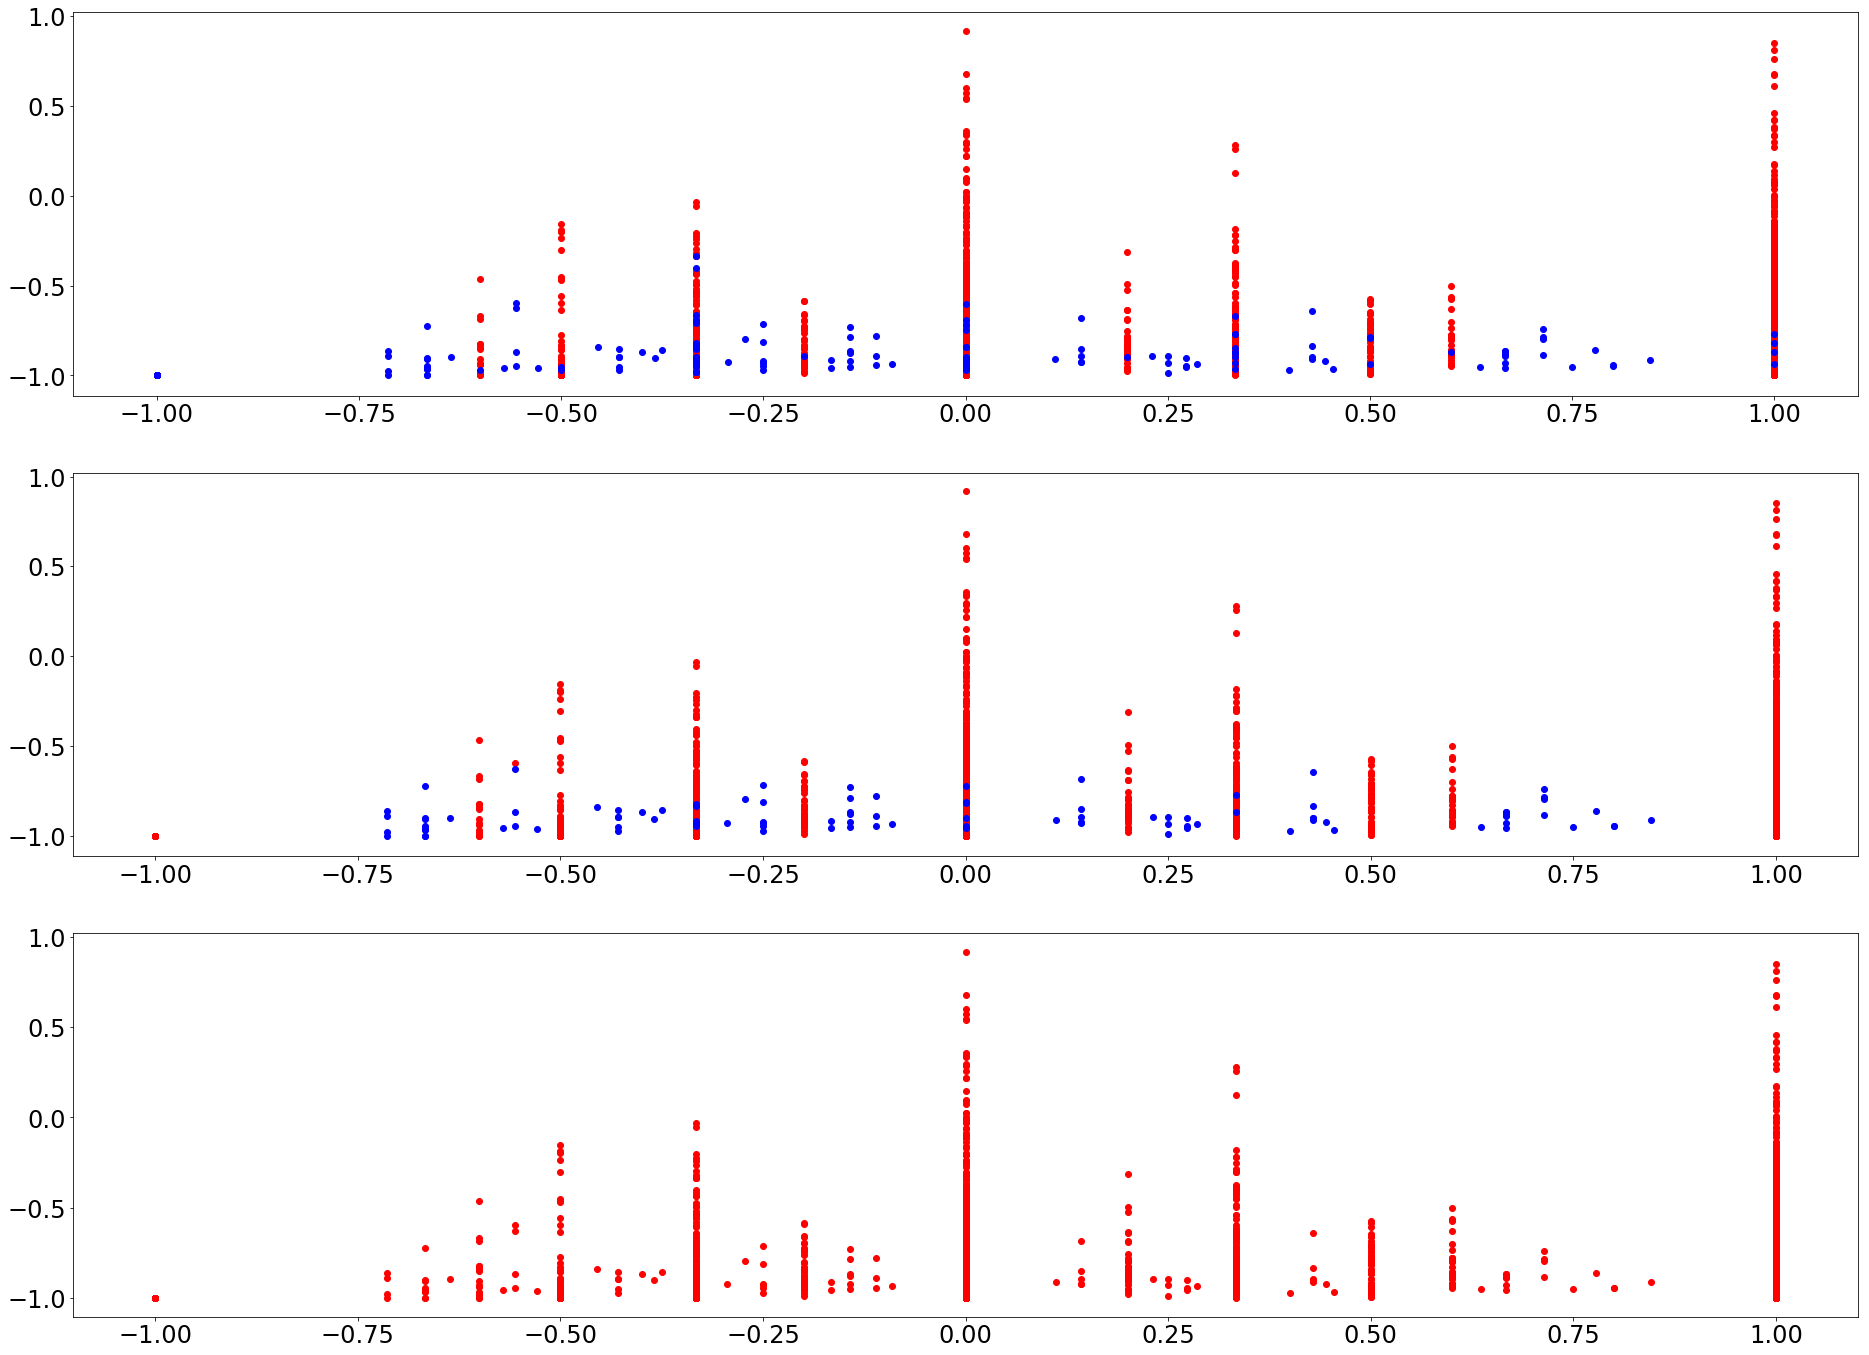

In [31]:
fig = plt.figure()

AS = [Xte[key] for key in [k for (k,v) in enumerate(Yte) if v == 0]]
BS = [Xte[key] for key in [k for (k,v) in enumerate(Yte) if v == 1]]
ax = fig.add_subplot( 3, 1, 1 )
ax.scatter([item[0] for item in AS], [item[1] for item in AS], c="r")
ax.scatter([item[0] for item in BS], [item[1] for item in BS], c="b")

AS = [Xte[key] for key in [k for (k,v) in enumerate(Pred) if v == 0]]
BS = [Xte[key] for key in [k for (k,v) in enumerate(Pred) if v == 1]]
ax = fig.add_subplot( 3, 1, 2 )
ax.scatter([item[0] for item in AS], [item[1] for item in AS], c="r")
ax.scatter([item[0] for item in BS], [item[1] for item in BS], c="b")

AS = [Xte[key] for key in [k for (k,v) in enumerate(Pre) if v == 0]]
BS = [Xte[key] for key in [k for (k,v) in enumerate(Pre) if v == 1]]
ax = fig.add_subplot( 3, 1, 3 )
ax.scatter([item[0] for item in AS], [item[1] for item in AS], c="r")
ax.scatter([item[0] for item in BS], [item[1] for item in BS], c="b")

plt.show()

### 5 fold KNN on whole data set

In [32]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
differenes = []
for train_index, test_index in kf.split(Xtr):
    X_train, X_test = [Xtr[i] for i in train_index], [Xtr[i] for i in test_index]
    y_train, y_test = [Ytr[i] for i in train_index], [Ytr[i] for i in test_index]
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(X_train, y_train)
    Pred = neigh.predict(X_test)
    differences = (difference(Pred, y_test)/len(y_test))
print(np.mean(differences))

0.00103403946118
